<a href="https://colab.research.google.com/github/mdazab/DATA5322-Homework-4/blob/main/hofidar_analysis_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Practical Homework 4: Unsupervised Learning

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

## Load Data

In [2]:
url = "https://raw.githubusercontent.com/mdazab/DATA5322-Homework-4/01ab29286c5ef1532b2ad99474b2236521119465/Hofidar_Cost_Center_Report.csv"
df = pd.read_csv(url)

df.head()

Year  License Number                                     Hospital Name  \
0  2018               1  Swedish Health Services DBA Swedish Medical Cent   
1  2019               1  Swedish Health Services DBA Swedish Medical Cent   
2  2020               1  Swedish Health Services DBA Swedish Medical Cent   
3  2021               1  Swedish Health Services DBA Swedish Medical Cent   
4  2022               1  Swedish Health Services DBA Swedish Medical Cent   

   Acct #              Cost Center  ID FTE s  Units of Measure  \
0    6010  ICU or Combined ICU-CCU    293.73             29562   
1    6010  ICU or Combined ICU-CCU    315.34             58040   
2    6010  ICU or Combined ICU-CCU    312.25             61858   
3    6010  ICU or Combined ICU-CCU    283.63             56193   
4    6010  ICU or Combined ICU-CCU    309.64             13801   

   Salaries Wages  Employee Benefits  Professional Fees  ...  Utilities  \
0        30226470            4609431            1896584  ...          0   
1        34310765            5176437            2695345  ...          0   
2        36778517            5080150            3275253  ...          0   
3        36710859            4990817            3525876  ...          0   
4        23232296            1105754             198446  ...          0   

   Other Noncategorized Expenses  Cost Recoveries  Operating Expenses  \
0                              0             1390            41624622   
1                              0            16480            47653505   
2                              0             6556            51674146   
3                              0            33657            51660408   
4                          77151                0            28887656   

   Allocated Expenses  Plant Sq Feet  Dietary Meals  Housekeeping Hours  \
0            43082868          85986         192205               10901   
1            47164648          85986         225238               11080   
2            47904192          85986         237665               10831   
3            48273323          85986              0              386564   
4                   0          50191              0                7496   

   Laundry Dry Lbs  Nursing FTE s  
0          1292872         192.05  
1          1537737         207.90  
2          1638252         205.13  
3            15922         181.60  
4                0         189.40  

[5 rows x 40 columns]

## Remove Categorial Variables

In [3]:
cat_names = df[['Year', 'License Number', 'Hospital Name', 'Acct #', 'Cost Center']]
df_clean = df.drop(columns=['Year', 'License Number', 'Hospital Name', 'Acct #', 'Cost Center'])


## Data QC

### Checking columns with Zeros, NaN or empty strings

Table for columns with Zeros, NaN, or empty strings

In [4]:
empty_string_count = (df.astype(str).apply(lambda x: x.str.strip()) == '').sum()
df_vis = df_clean.apply(pd.to_numeric, errors='coerce')
n_rows = len(df_vis)

summary = pd.DataFrame({
    'Zero Count': (df_vis == 0).sum(),
    'NaN Count': df_vis.isna().sum(),
    'Empty String Count': empty_string_count
})
summary['Zero %'] = (summary['Zero Count'] / n_rows) * 100
summary['NaN %'] = (summary['NaN Count'] / n_rows) * 100
summary['Empty String %'] = (summary['Empty String Count'] / n_rows) * 100
summary = summary[(summary['Zero Count'] > 0) |
                  (summary['NaN Count'] > 0) |
                  (summary['Empty String Count'] > 0)]

summary = summary.sort_values(by='Zero Count', ascending=False)

summary.style.format({
    'Zero %': '{:.2f}%',
    'NaN %': '{:.2f}%',
    'Empty String %': '{:.2f}%',
    'Zero Count': '{:,}',
    'NaN Count': '{:,}',
    'Empty String Count': '{:,}'
})

Columns only had Zero values, we did not find NaN nor empty string values. Next, plotted the distribution of Zeros across columns.

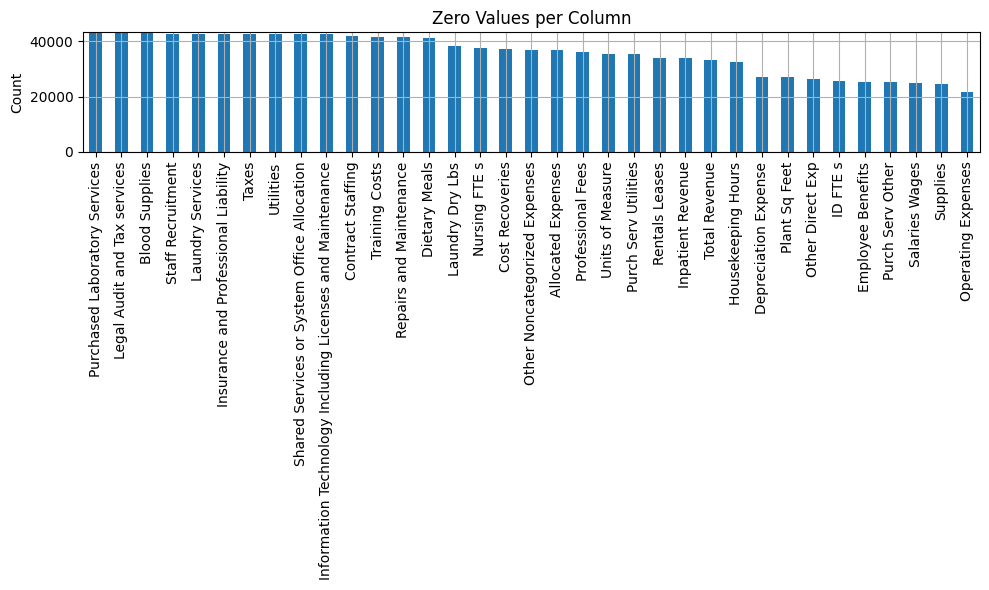

In [5]:
zero_counts = (df_vis == 0).sum().sort_values(ascending=False)
zero_counts = zero_counts[zero_counts > 0]

plt.figure(figsize=(10, 6))
zero_counts.plot(kind='bar')
plt.ylim(0, len(df_vis))
plt.title("Zero Values per Column")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

### Checking for Min and Max Values

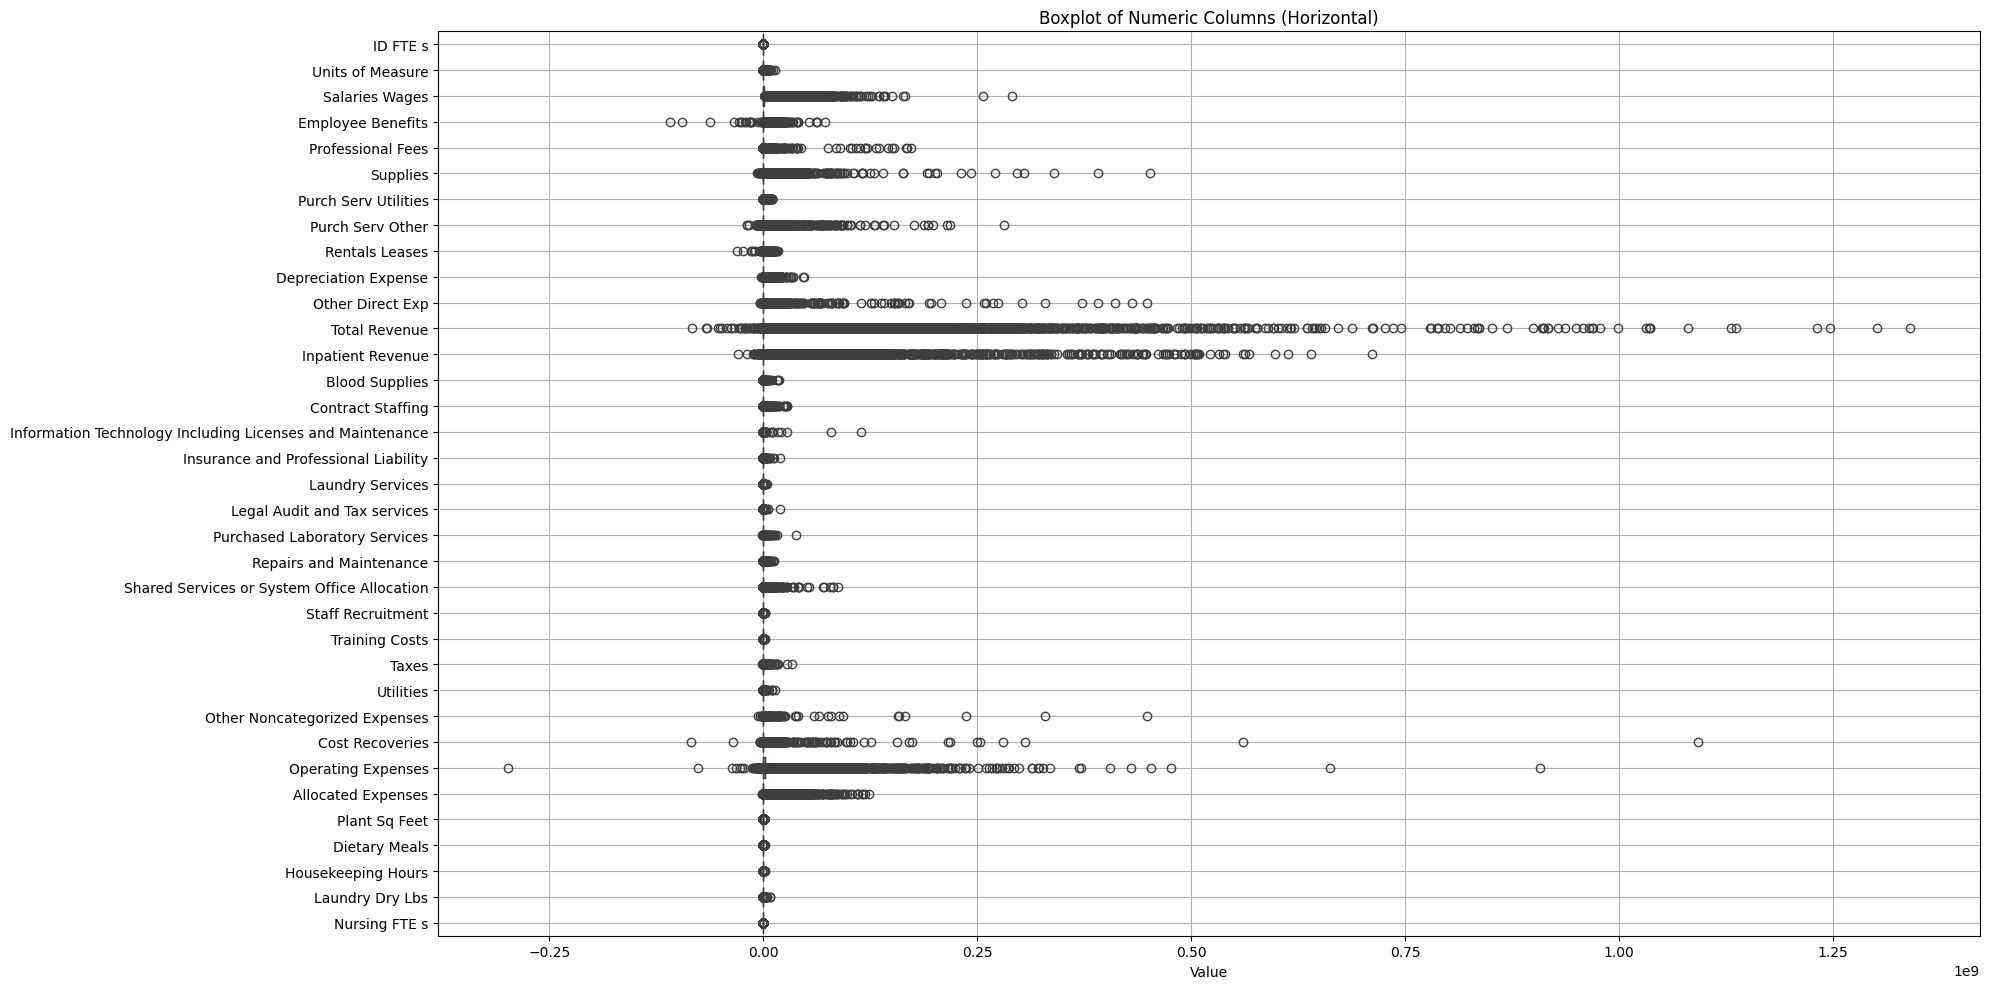

In [6]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_vis, orient='h')
plt.title("Boxplot of Numeric Columns (Horizontal)")
plt.xlabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Checking for Negative values

In [7]:
neg_counts_by_column = (
    df[df.select_dtypes(include='number').lt(0).any(axis=1)]
    .melt(value_vars=df.select_dtypes(include='number').columns)
    .query('value < 0')
    .groupby('variable')
    .size()
    .reset_index(name='Negative Count')
    .sort_values(by='Negative Count', ascending=False)
)

print(neg_counts_by_column.to_string(index=False))

                                                 variable  Negative Count
                                                 Supplies             471
                                         Other Direct Exp             394
                                       Operating Expenses             335
                                         Purch Serv Other             298
                                           Rentals Leases             231
                            Other Noncategorized Expenses             211
                                          Cost Recoveries             199
                                        Professional Fees             162
                                        Inpatient Revenue             118
                                            Total Revenue              90
                                        Employee Benefits              89
                                        Contract Staffing              78
                                     P

####  Columns with Negative Values

- Financial: Salaries Wages, Supplies, Depreciation Expense, Total Revenue
- Staffing: ID FTEs, Nursing FTEs
- Resources: Utilities, Purchased Laboratory **Services**

### Commonalities between columns with Negative Values

In [8]:
neg_summary = (
    df[df.select_dtypes(include='number').lt(0).any(axis=1)]
    .groupby(['Cost Center'])
    .size()
    .reset_index(name='Count')
    .sort_values(by='Count', ascending=False)
)
print(neg_summary.to_string(index=False))

                        Cost Center  Count
               Other Admin Services    168
                         Purchasing    139
                   Central Services    134
            Hospital Administration     94
                            Dietary     64
           Other Ancillary Services     64
                  Laundry and Linen     53
             Other General Services     51
             Radiology - Diagnostic     47
                         Acute Care     47
                         Anesthesia     42
                              Plant     40
                            Clinics     40
                          Personnel     39
                       Housekeeping     38
                   Physical Therapy     38
                   Patient Accounts     37
                    Data Processing     37
                           Pharmacy     36
             Nursing Administration     35
Accounting or Total Fiscal Services     35
                Respiratory Therapy     34
           

#### What should we do?
- Remove the cost center with negative adjustments/refunts/data entry errors?

#### **Solution to Zero values in dataset**
Aggregate values by Hospital and Year
- It will help us reduce the noise from cost centers with lots of missing data
- Allows for bettter handling of missing data, easier to impute at hospital-level
- We can focus on hospital-wide trends, not departmental operations
- Results would focus on spending or revenue
- Easier data preparation for PCA, clustering

### Aggregate values by Hospital and Year

In [9]:
# Aggregate values of starting data frame.
df_agg = df.groupby(['Hospital Name', 'Year'], as_index=False).sum(numeric_only=True)


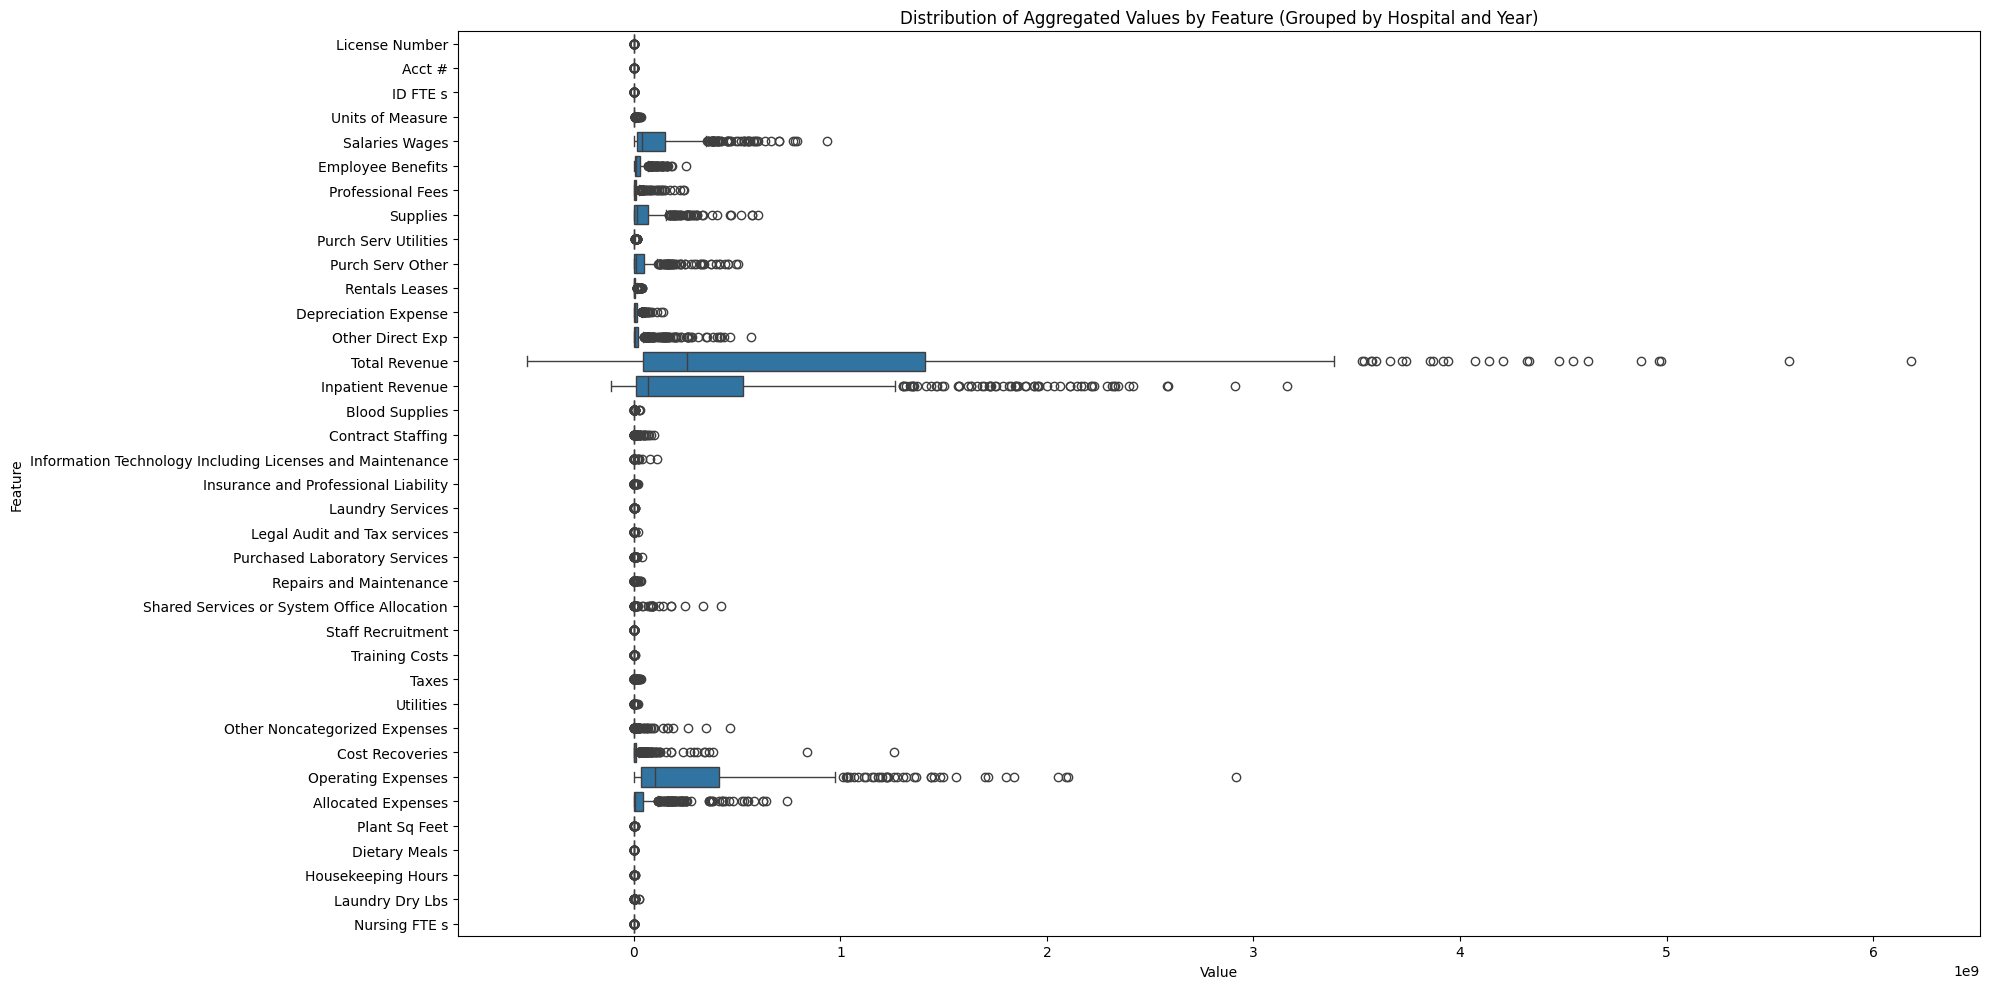

In [10]:
# Show distribution of aggregated values grouped by 'Hospital' and 'Year
df_grouped = df.groupby(['Hospital Name', 'Year'], as_index=False).sum(numeric_only=True)
df_melted = df_grouped.melt(id_vars=['Hospital Name', 'Year'], var_name='Feature', value_name='Value')

plt.figure(figsize=(20, 10))
sns.boxplot(data=df_melted, x='Value', y='Feature', orient='h')
plt.title("Distribution of Aggregated Values by Feature (Grouped by Hospital and Year)")
plt.xlabel("Value")
plt.tight_layout()
plt.show()

In [11]:
n_rows = len(df_agg)
summary = pd.DataFrame({
    'Zero Count': (df_agg == 0).sum(),
})
summary['Zero %'] = (summary['Zero Count'] / n_rows) * 100
summary = summary[(summary['Zero Count'] > 0) ]
summary = summary.sort_values(by='Zero Count', ascending=False)

summary.style.format({
    'Zero %': '{:.2f}%',
    'Zero Count': '{:,}'
})

In [ ]:
df_agg.shape

(566, 55)

**Comment**: 32/55 columns had more than 37% of their values equal to zero. I best approach would be to binary encode these columns, instead of reporting a numerical cost we could encode them as 0 if their initial value was zero to represent the hospital does not offer this service. Code these columns as 1 if they had a numerical value, which says they offer this service.

In [12]:
# List of columns to binary encode
sparse_service_cols = [
    "Purchased Laboratory Services", "Utilities",
    "Shared Services or System Office Allocation", "Laundry Services",
    "Information Technology Including Licenses and Maintenance",
    "Blood Supplies", "Legal Audit and Tax services", "Staff Recruitment",
    "Contract Staffing", "Training Costs", "Taxes", "Repairs and Maintenance",
    "Insurance and Professional Liability", "Other Noncategorized Expenses",
    "Allocated Expenses", "Cost Recoveries"
]

# Generate new columns with binary encoded value. Columns will be labeled with '_flag' at the end for easier identification
for col in sparse_service_cols:
    df_agg[col + "_flag"] = (df_agg[col] > 0).astype(int)

# Drop original columns with large number of zero values
df_encoded = df_agg.drop(columns=sparse_service_cols)

**Note**: Ok to delete plot

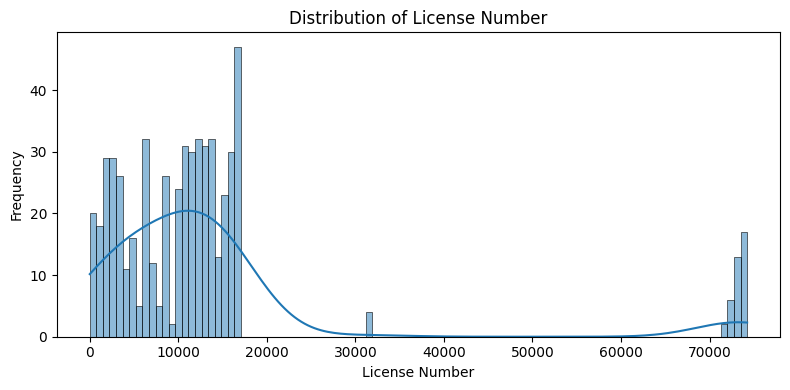

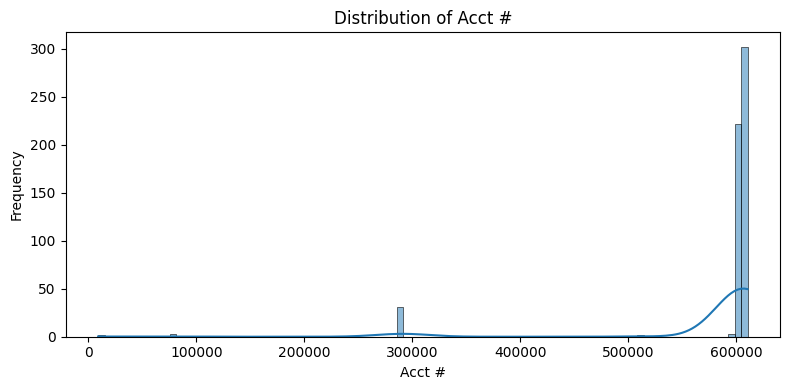

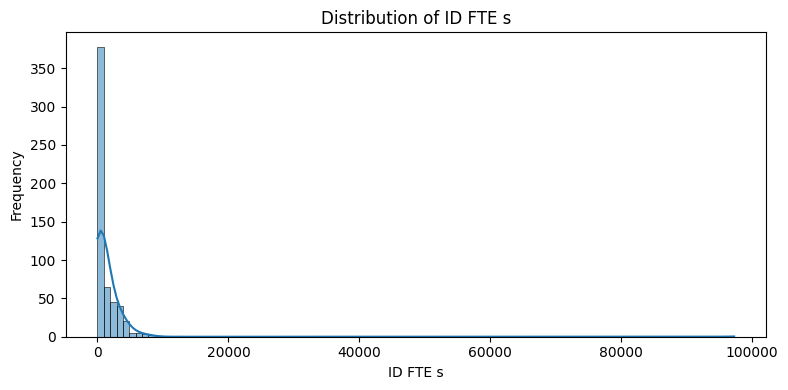

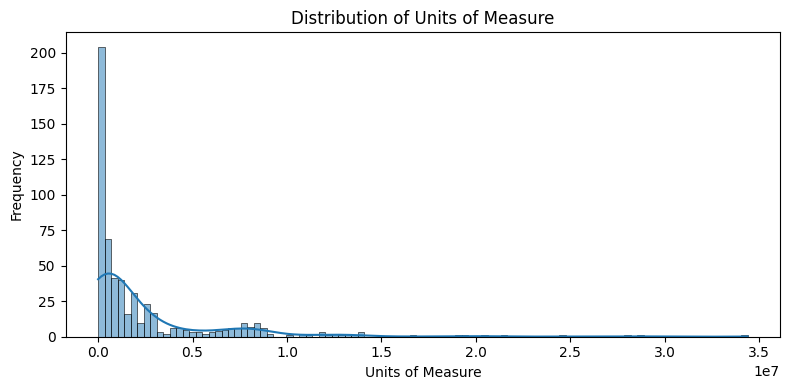

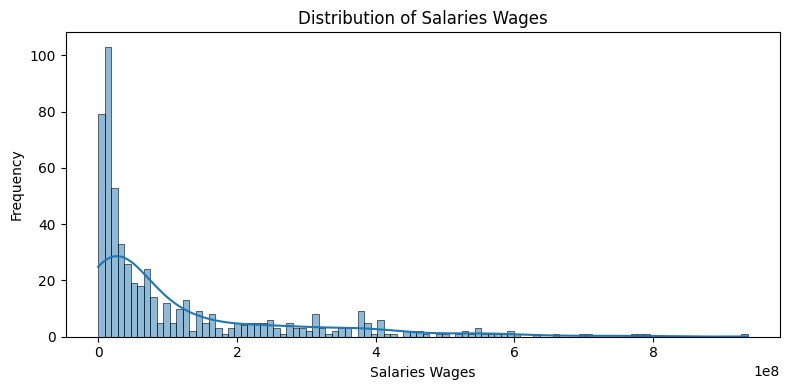

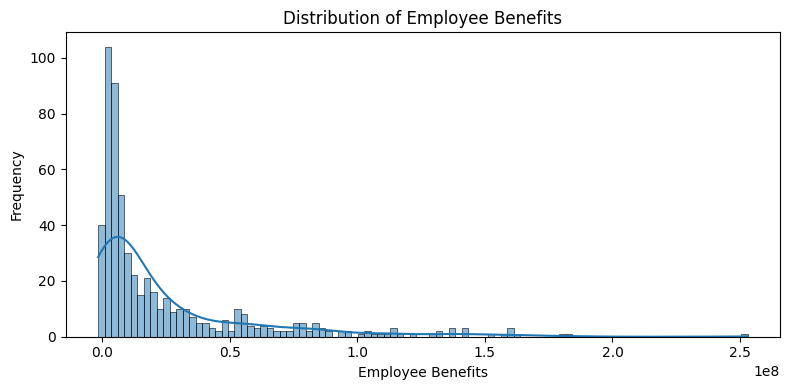

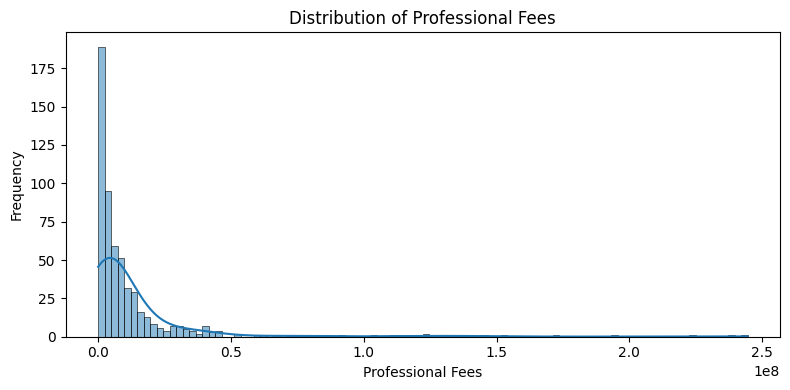

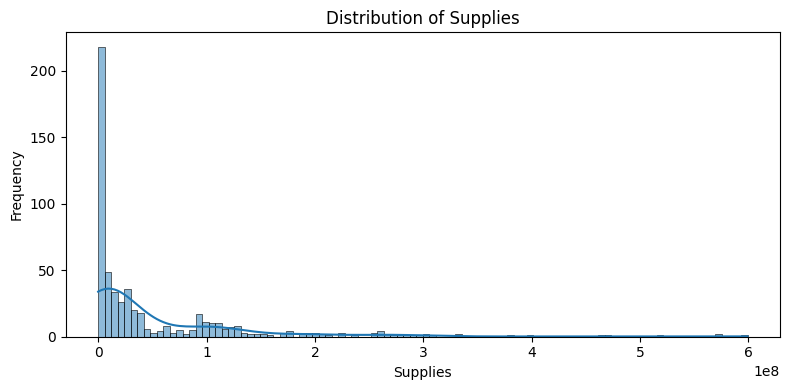

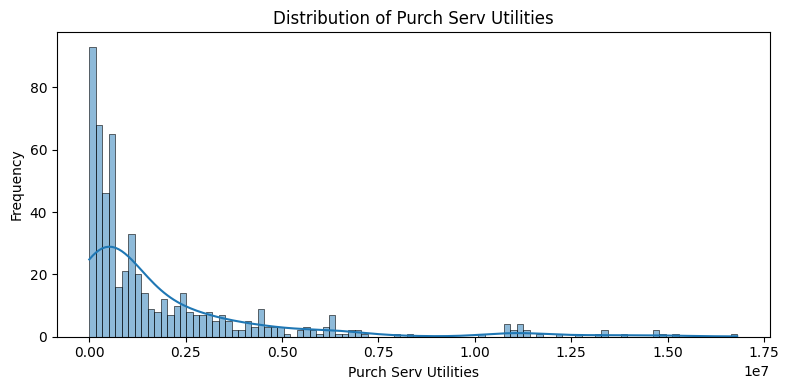

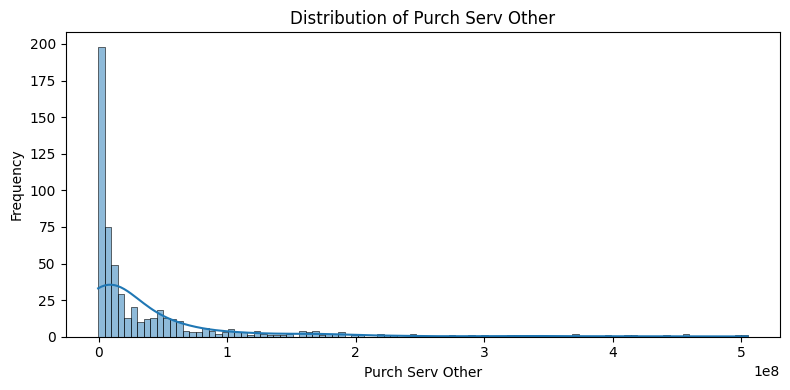

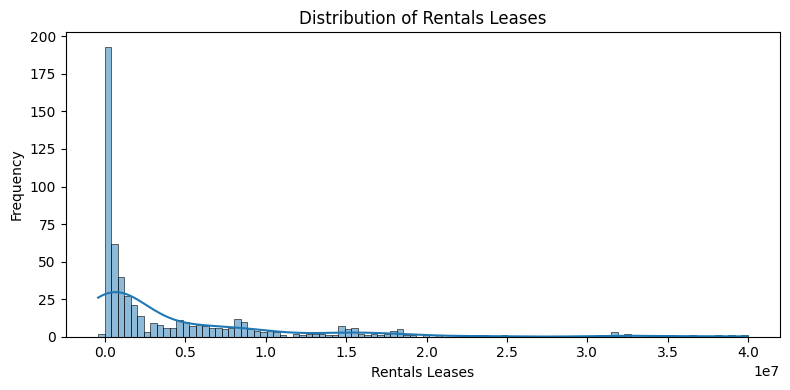

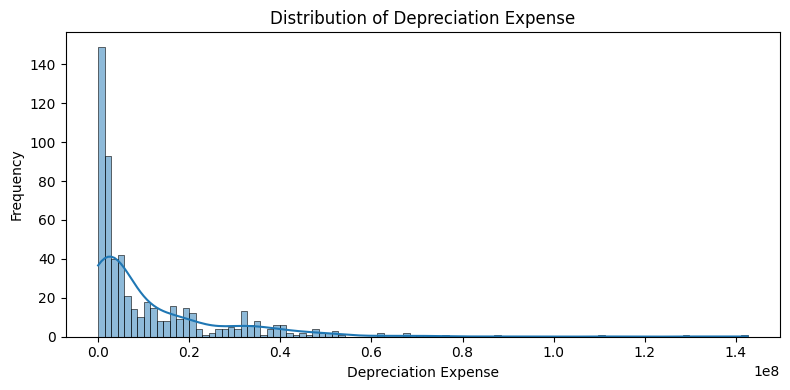

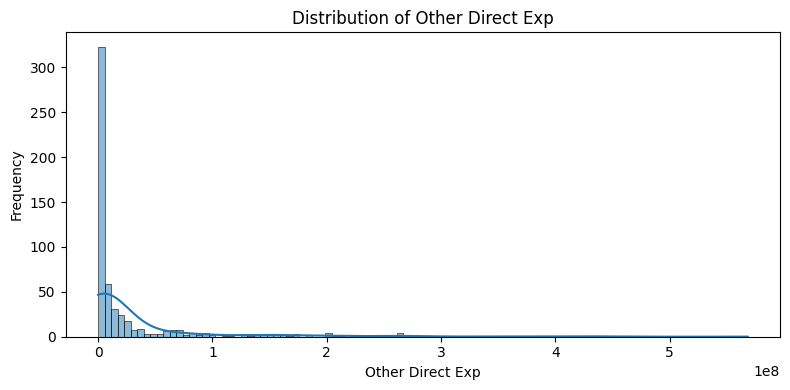

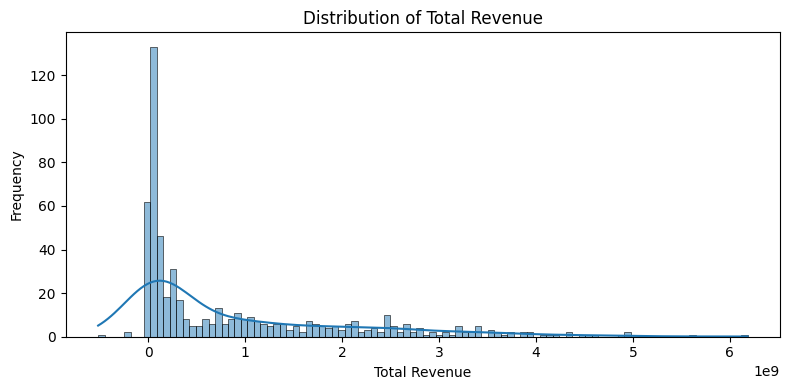

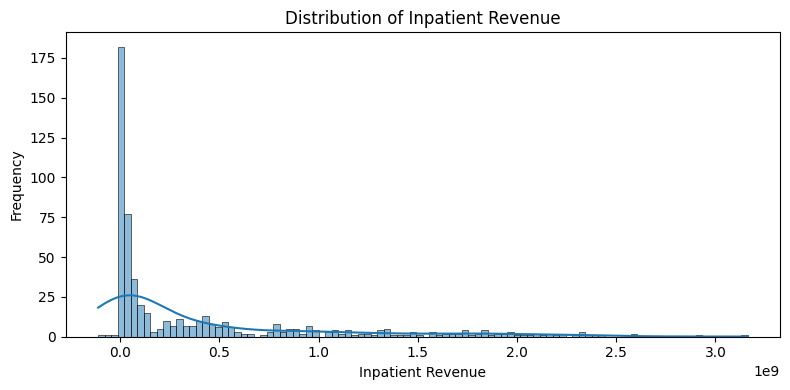

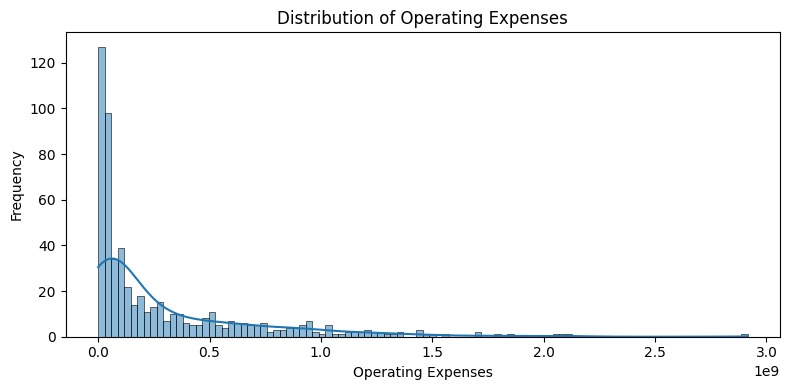

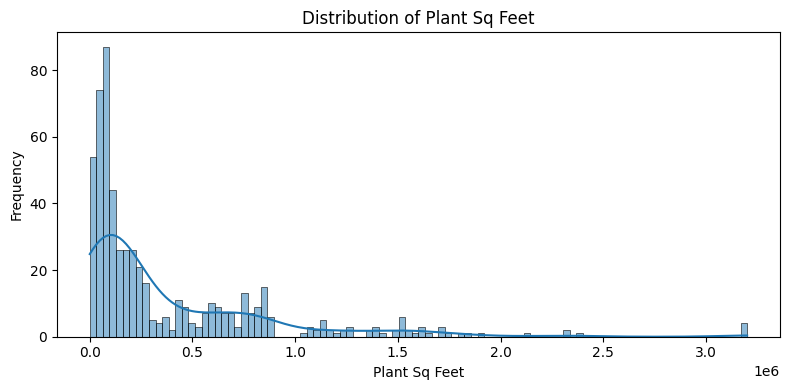

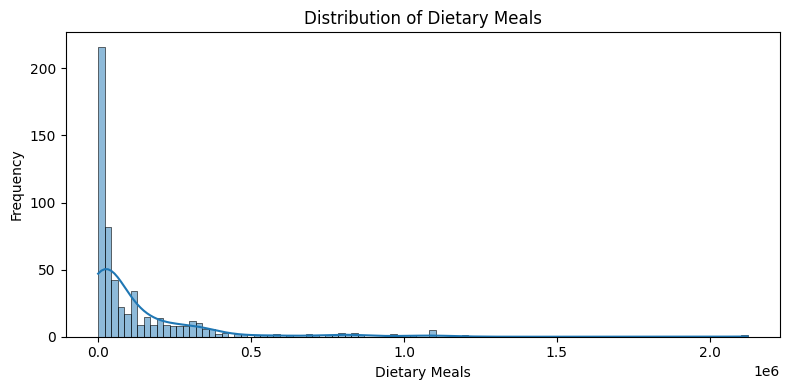

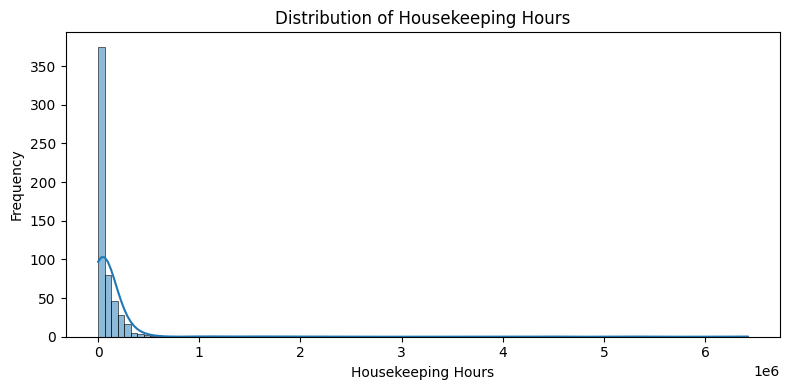

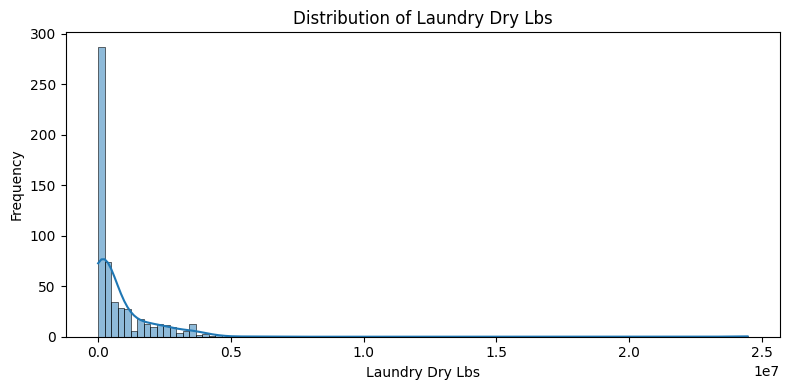

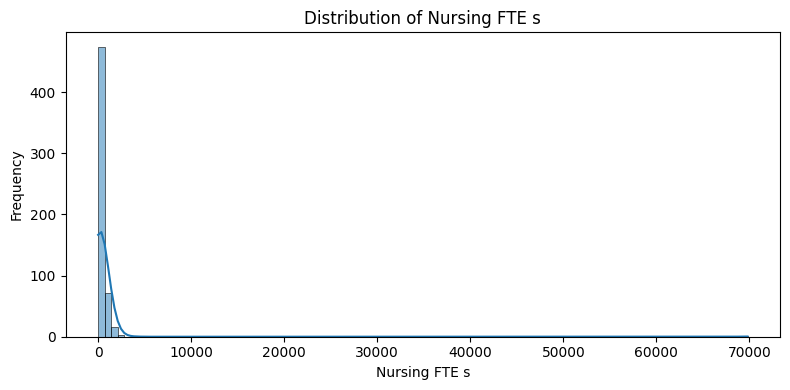

In [13]:
numeric_cols = [col for col in df_encoded.select_dtypes(include='number').columns if not col.endswith('_flag') and col not in ['Year']]

# Plot distribution for each
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_encoded[col], kde=True, bins=100)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

Displaying a snip of the binary encoded and non-binary encoded table.

In [14]:
df_encoded.head(10)

Hospital Name  Year  License Number  Acct #  ID FTE s  \
0  ASTRIA TOPPENISH HOSPITAL  2020            6766  291190     45.57   
1  ASTRIA TOPPENISH HOSPITAL  2021            6766  291190     59.88   
2  ASTRIA TOPPENISH HOSPITAL  2022           15721  601720    256.76   
3  ASTRIA TOPPENISH HOSPITAL  2023           15721  601720    233.13   
4               Arbor Health  2019           13840  610720     50.00   
5               Arbor Health  2020           13840  610720    176.27   
6               Arbor Health  2021           13840  610720    199.00   
7               Arbor Health  2022           13667  601720    200.90   
8               Arbor Health  2023           13667  601720    205.00   
9  Astria Sunnyside Hospital  2019           15840  610720    473.32   

   Units of Measure  Salaries Wages  Employee Benefits  Professional Fees  \
0             99640         1988881           -1627202               3500   
1             98840         2307159            -953893              39630   
2            115137        21035918            4468660            4767567   
3            104327        23073548            4466960             744897   
4            274824        14806725            3468802            2117301   
5            251459        17202430            3929505            1703174   
6            264774        18707786            4143764            1380397   
7            290075        21427371            3914496            1648430   
8            302689        22446603            4452887            1453059   
9            693578        36116458            6817786            1156689   

   Supplies  ...  Legal Audit and Tax services_flag  Staff Recruitment_flag  \
0    484780  ...                                  0                       0   
1    597656  ...                                  0                       0   
2   5974762  ...                                  0                       0   
3   6625476  ...                                  0                       0   
4   1893282  ...                                  0                       0   
5   2072897  ...                                  0                       0   
6   2330582  ...                                  0                       0   
7   2771740  ...                                  0                       0   
8   3068894  ...                                  0                       0   
9  15276312  ...                                  0                       0   

   Contract Staffing_flag  Training Costs_flag  Taxes_flag  \
0                       0                    0           0   
1                       0                    0           0   
2                       1                    0           1   
3                       1                    0           1   
4                       0                    0           0   
5                       0                    0           0   
6                       0                    0           0   
7                       0                    0           0   
8                       0                    0           0   
9                       0                    0           0   

   Repairs and Maintenance_flag  Insurance and Professional Liability_flag  \
0                             0                                          0   
1                             0                                          0   
2                             1                                          1   
3                             1                                          1   
4                             0                                          0   
5                             0                                          0   
6                             0                                          0   
7                             0                                          0   
8                             0                                          1   
9                             0          

#### Remove categorical columns such as 'Hospital Name', 'Year', 'License Number', 'Acct #'

We will store this information as meta data for labeling in future plots.

In [15]:
# List of categorical columns.
meta_cols = ['Hospital Name', 'Year', 'License Number', 'Acct #']

# List of binary enconded columns
binary_cols = [col for col in df_encoded.columns if col.endswith('_flag')]

# List of numeric columns
numeric_cols = [col for col in df_encoded.columns if col not in meta_cols + binary_cols]

# Store metadata for categorical columns separately
df_meta = df_encoded[meta_cols].reset_index(drop=True)

# Scale only the selected numeric columns
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded[numeric_cols]), columns=numeric_cols)

# Add binary encoded columns (unscaled)
df_scaled[binary_cols] = df_encoded[binary_cols].reset_index(drop=True)

In [26]:
meta_cols = ['Hospital Name', 'Year', 'License Number', 'Acct #']
binary_cols = [col for col in df_encoded.columns if col.endswith('_flag')]
numeric_cols = [col for col in df_encoded.columns if col not in meta_cols + binary_cols]

# Store metadata
df_meta = df_encoded[meta_cols].reset_index(drop=True)

# Scale both numeric and binary columns
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_encoded[numeric_cols + binary_cols])
df_scaled = pd.DataFrame(scaled_values, columns=numeric_cols + binary_cols)

#### Plot distribution of scaled data

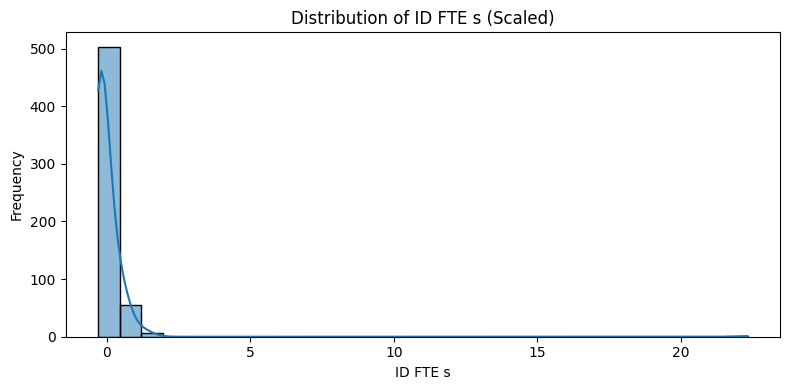

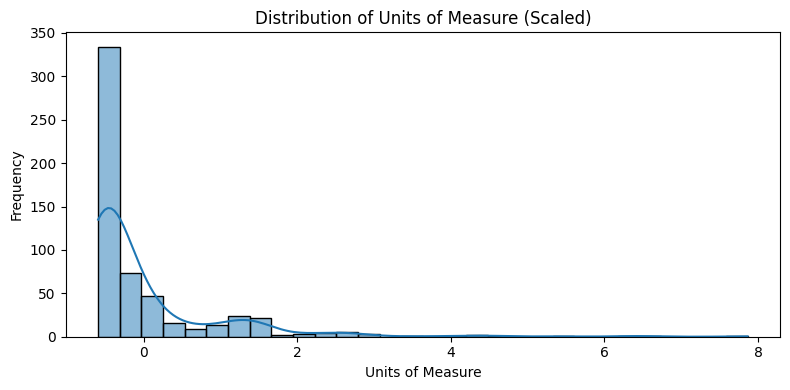

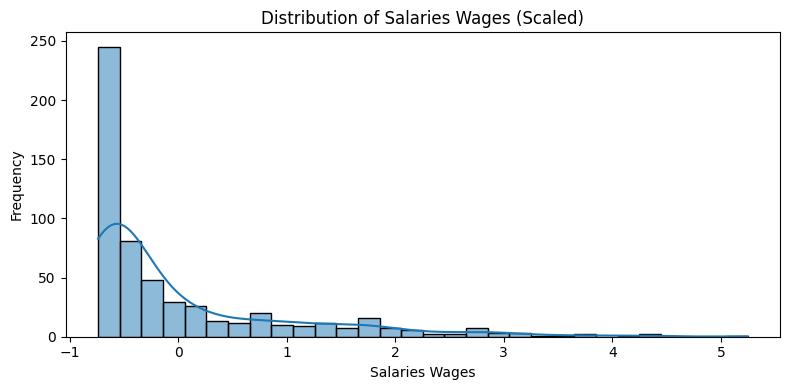

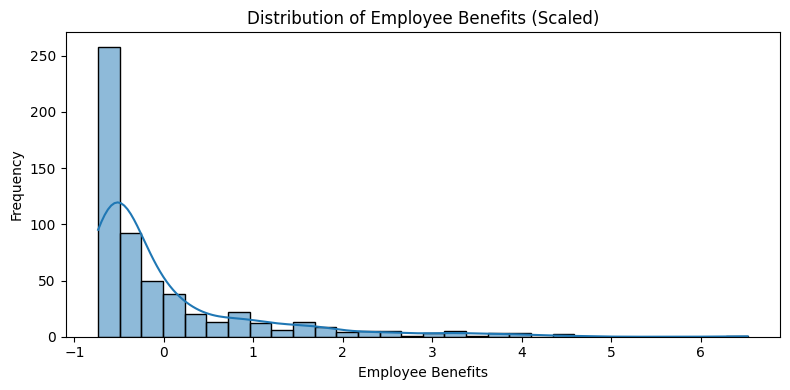

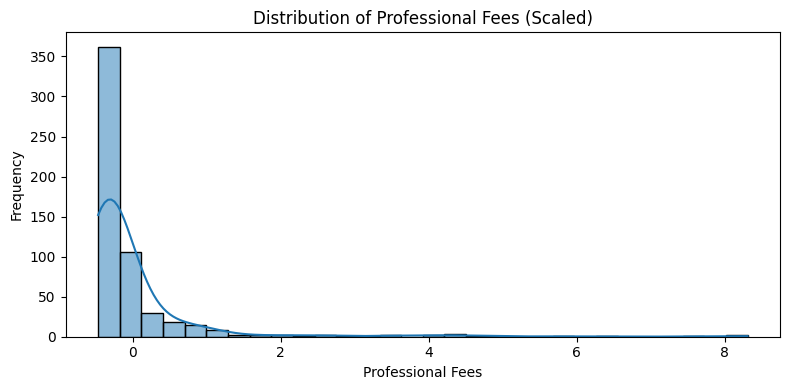

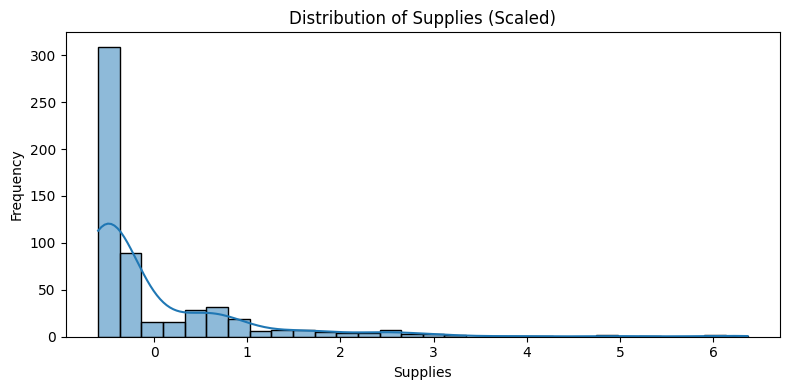

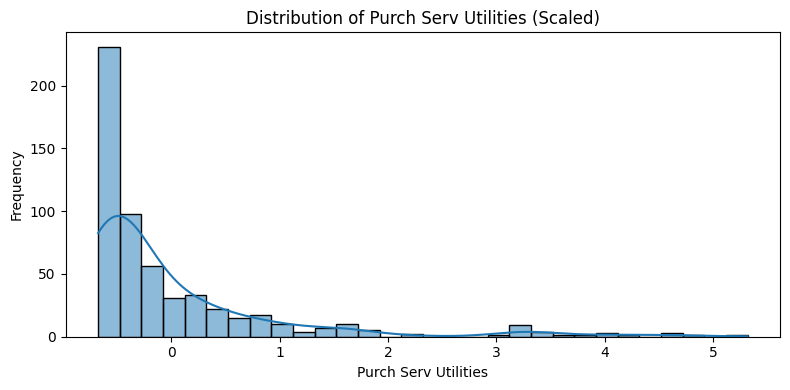

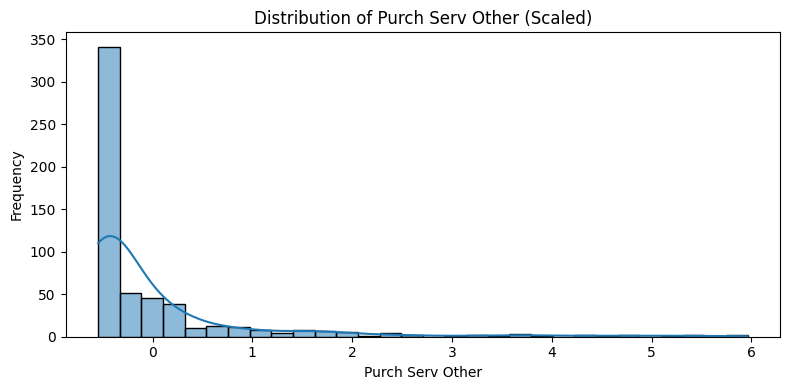

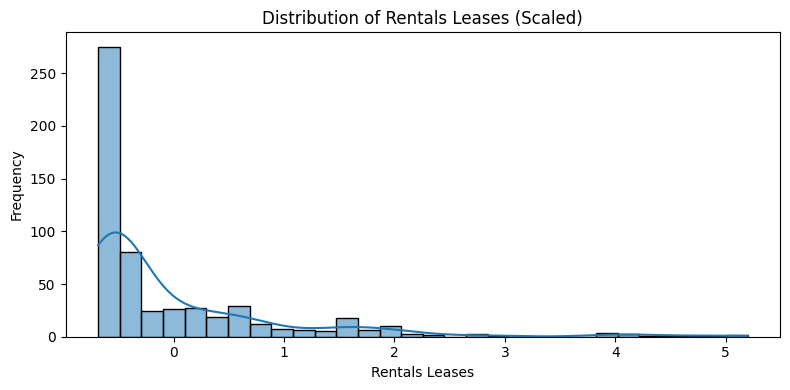

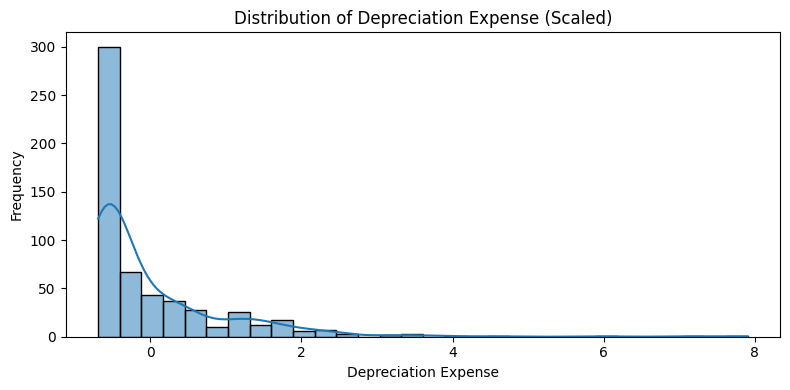

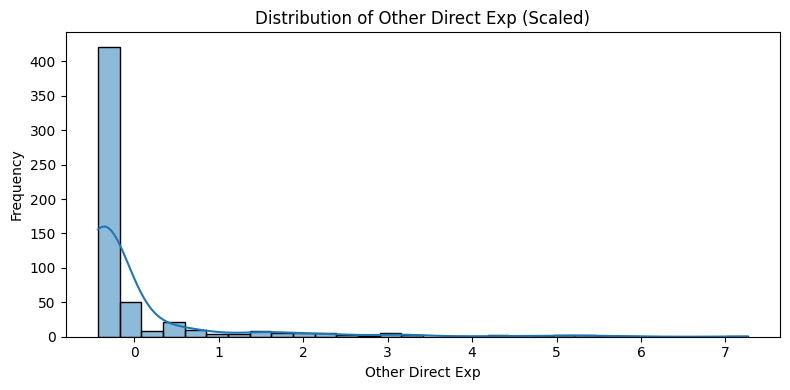

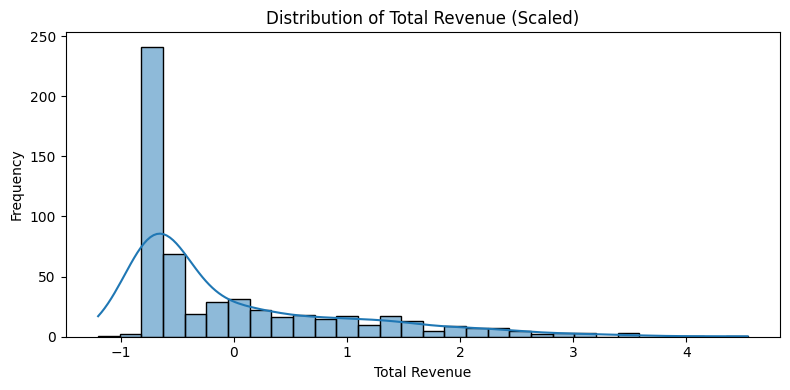

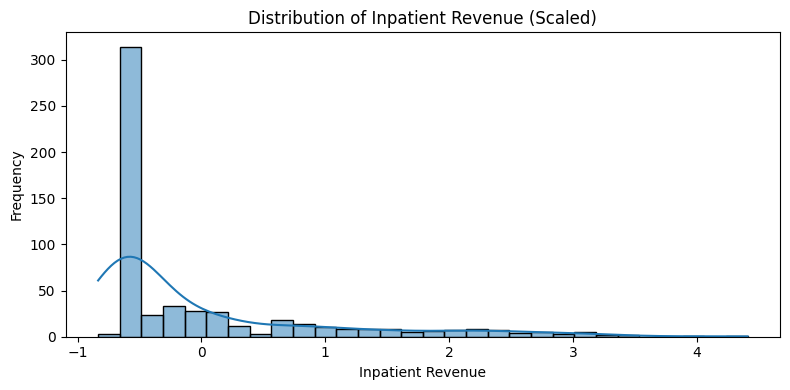

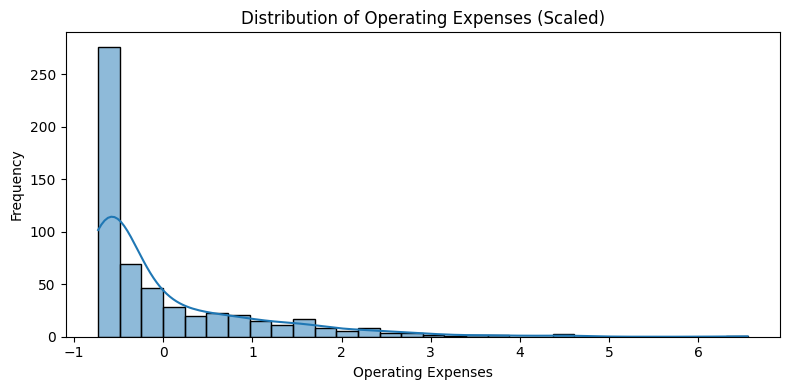

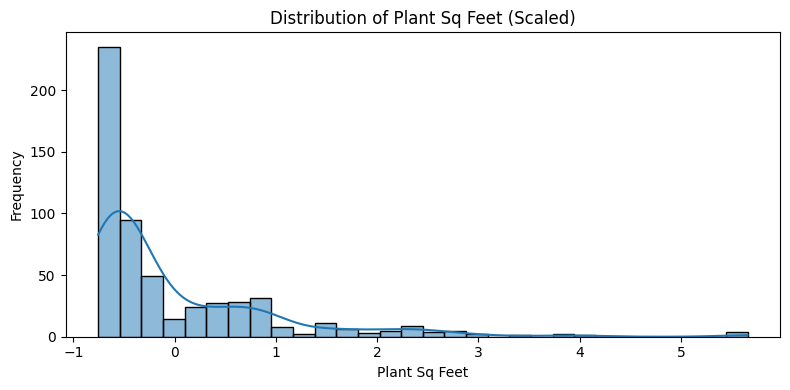

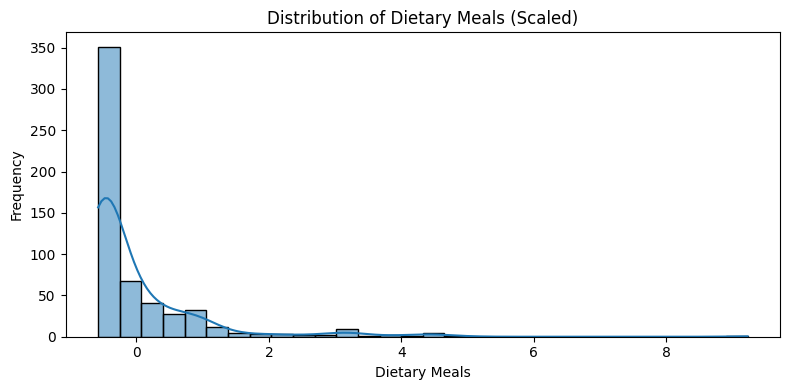

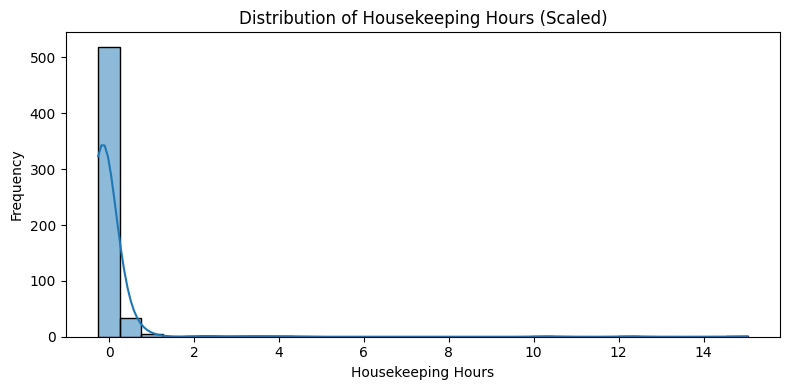

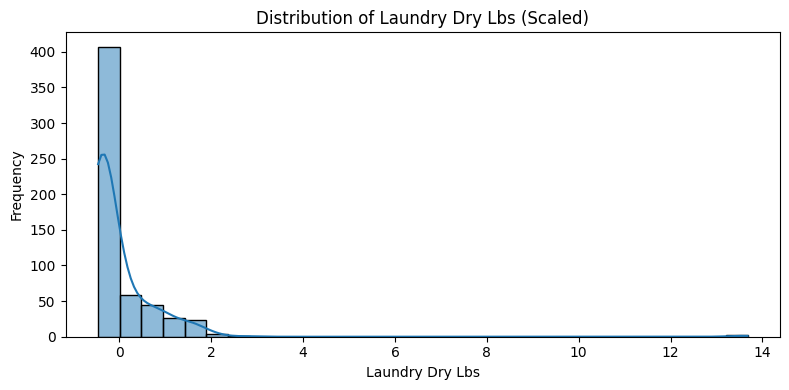

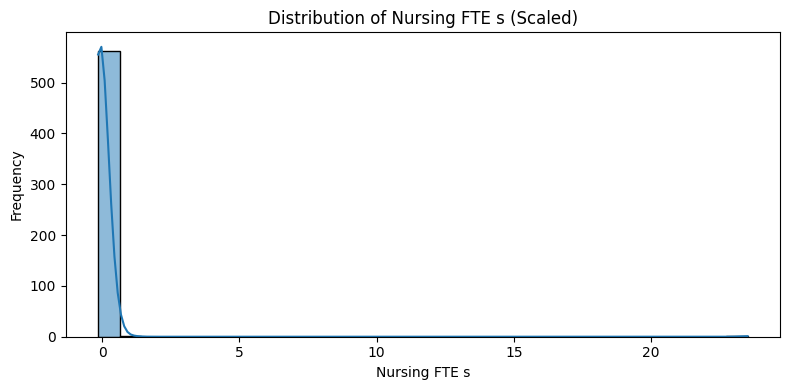

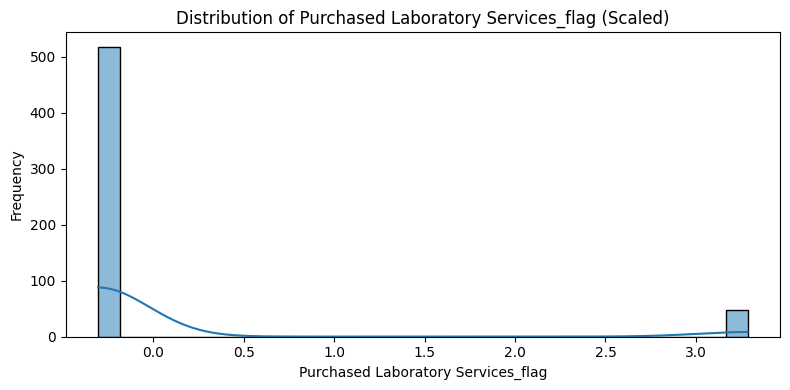

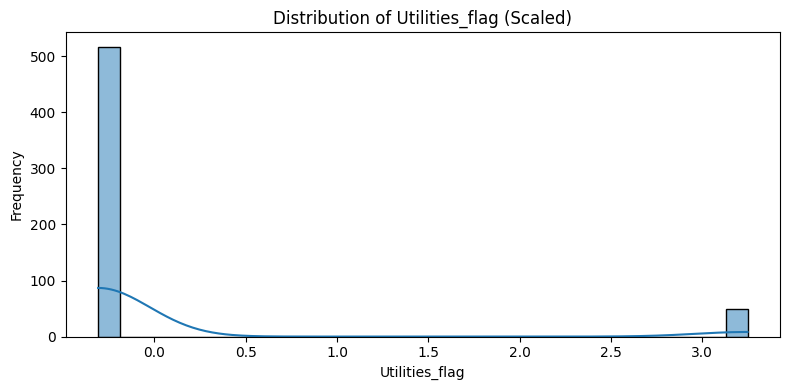

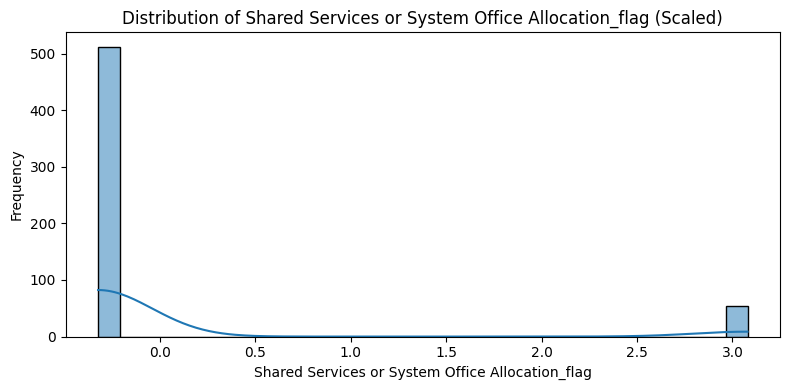

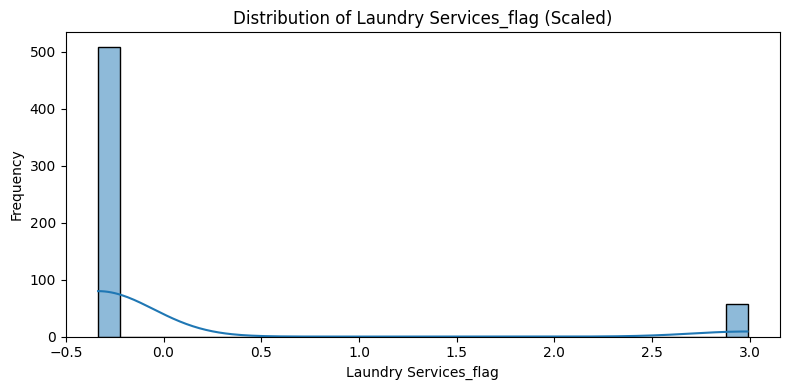

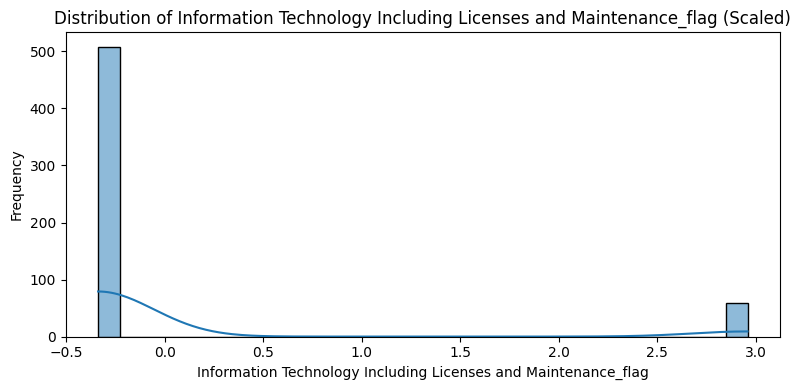

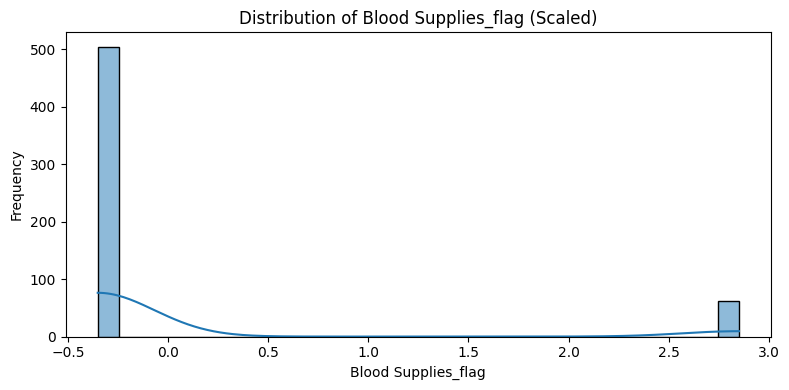

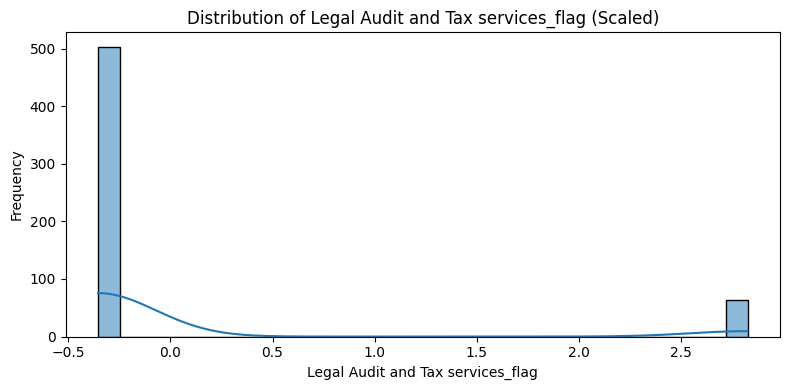

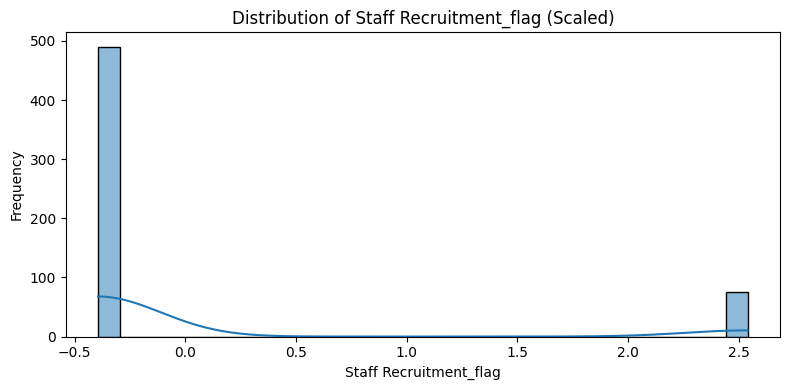

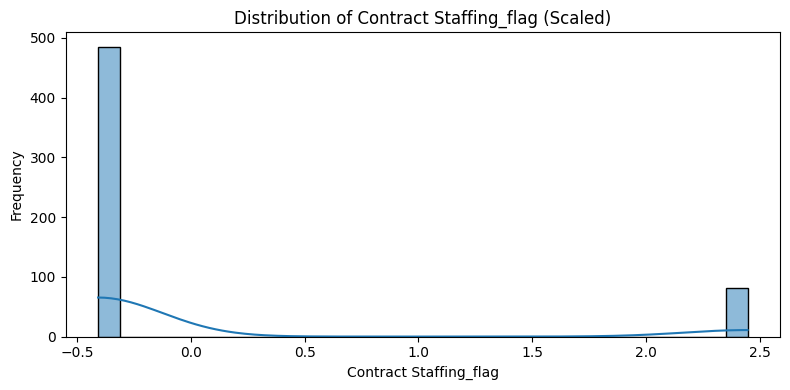

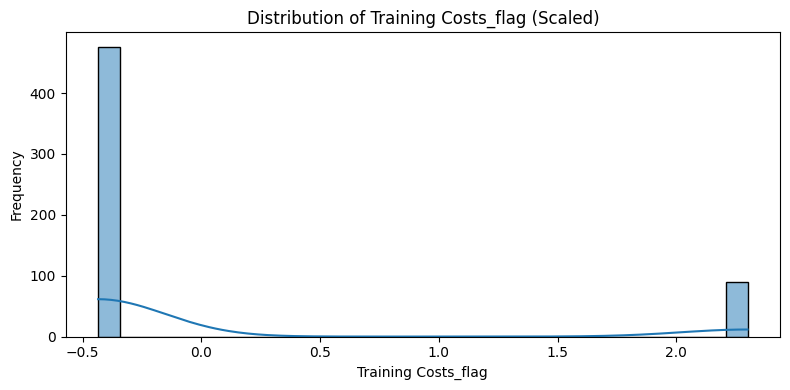

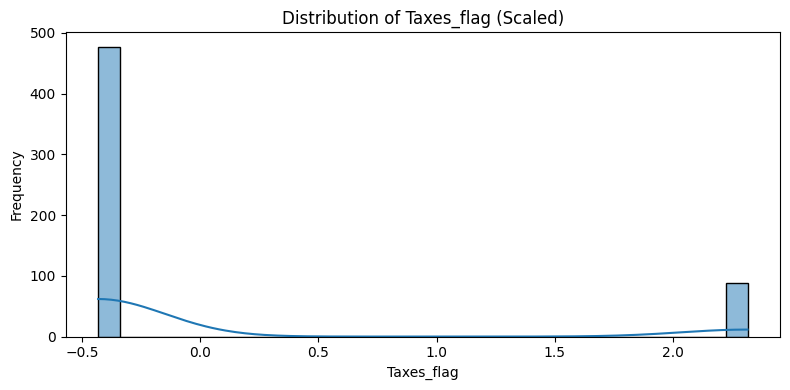

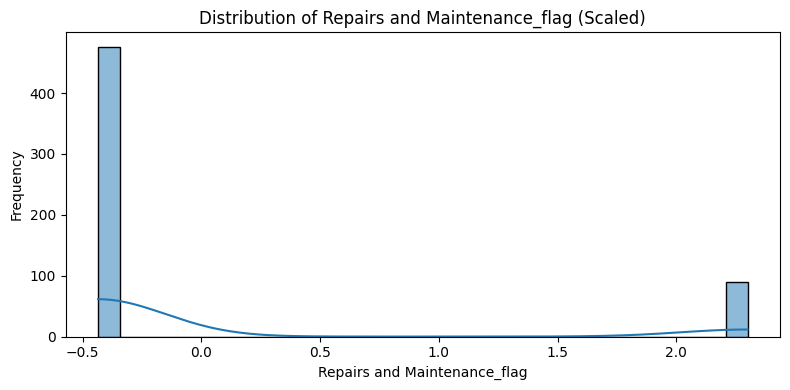

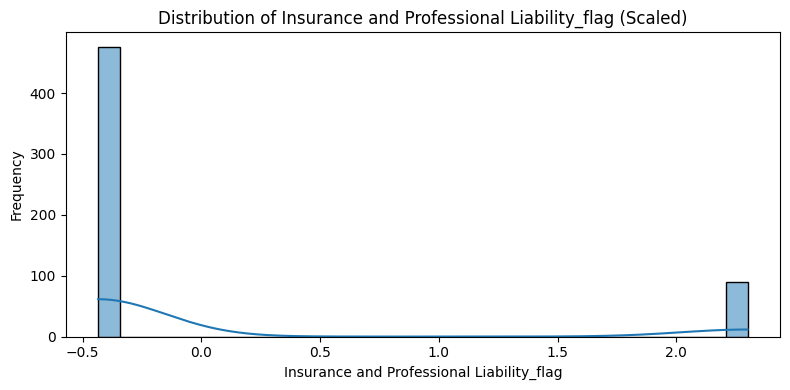

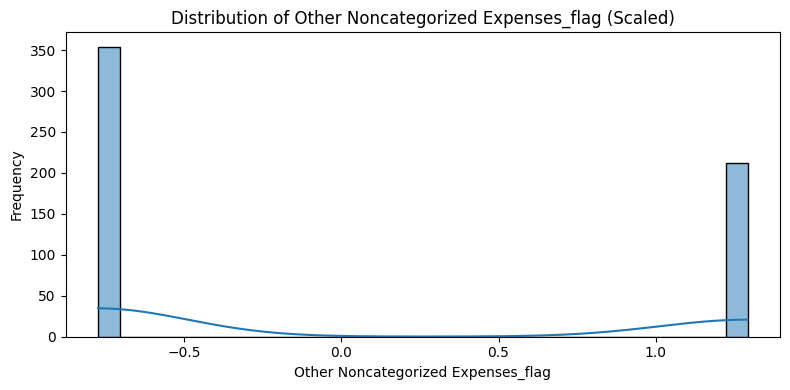

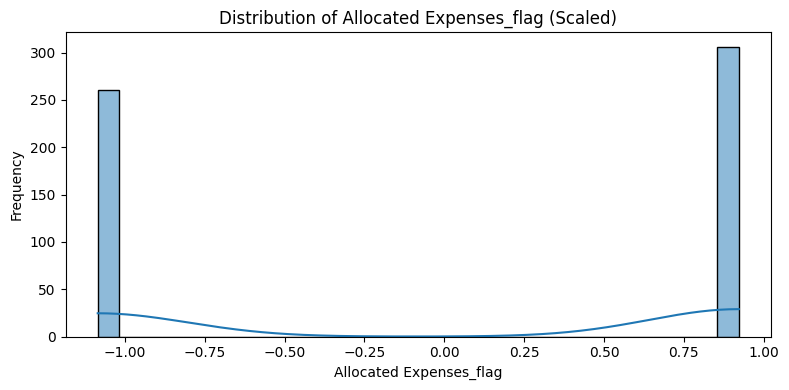

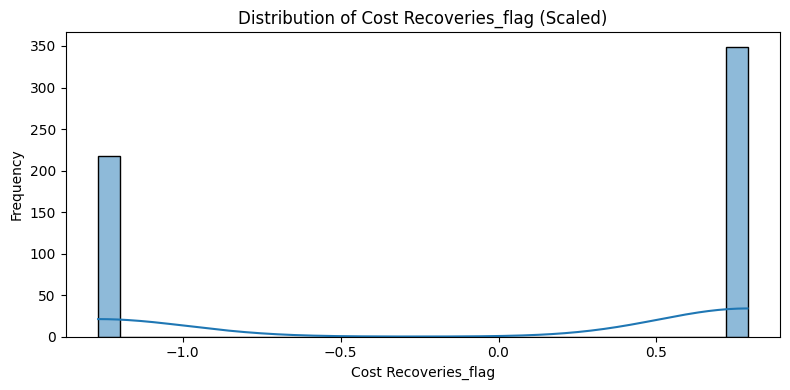

In [27]:
for col in df_scaled.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_scaled[col], kde=True, bins=30)
    plt.title(f"Distribution of {col} (Scaled)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

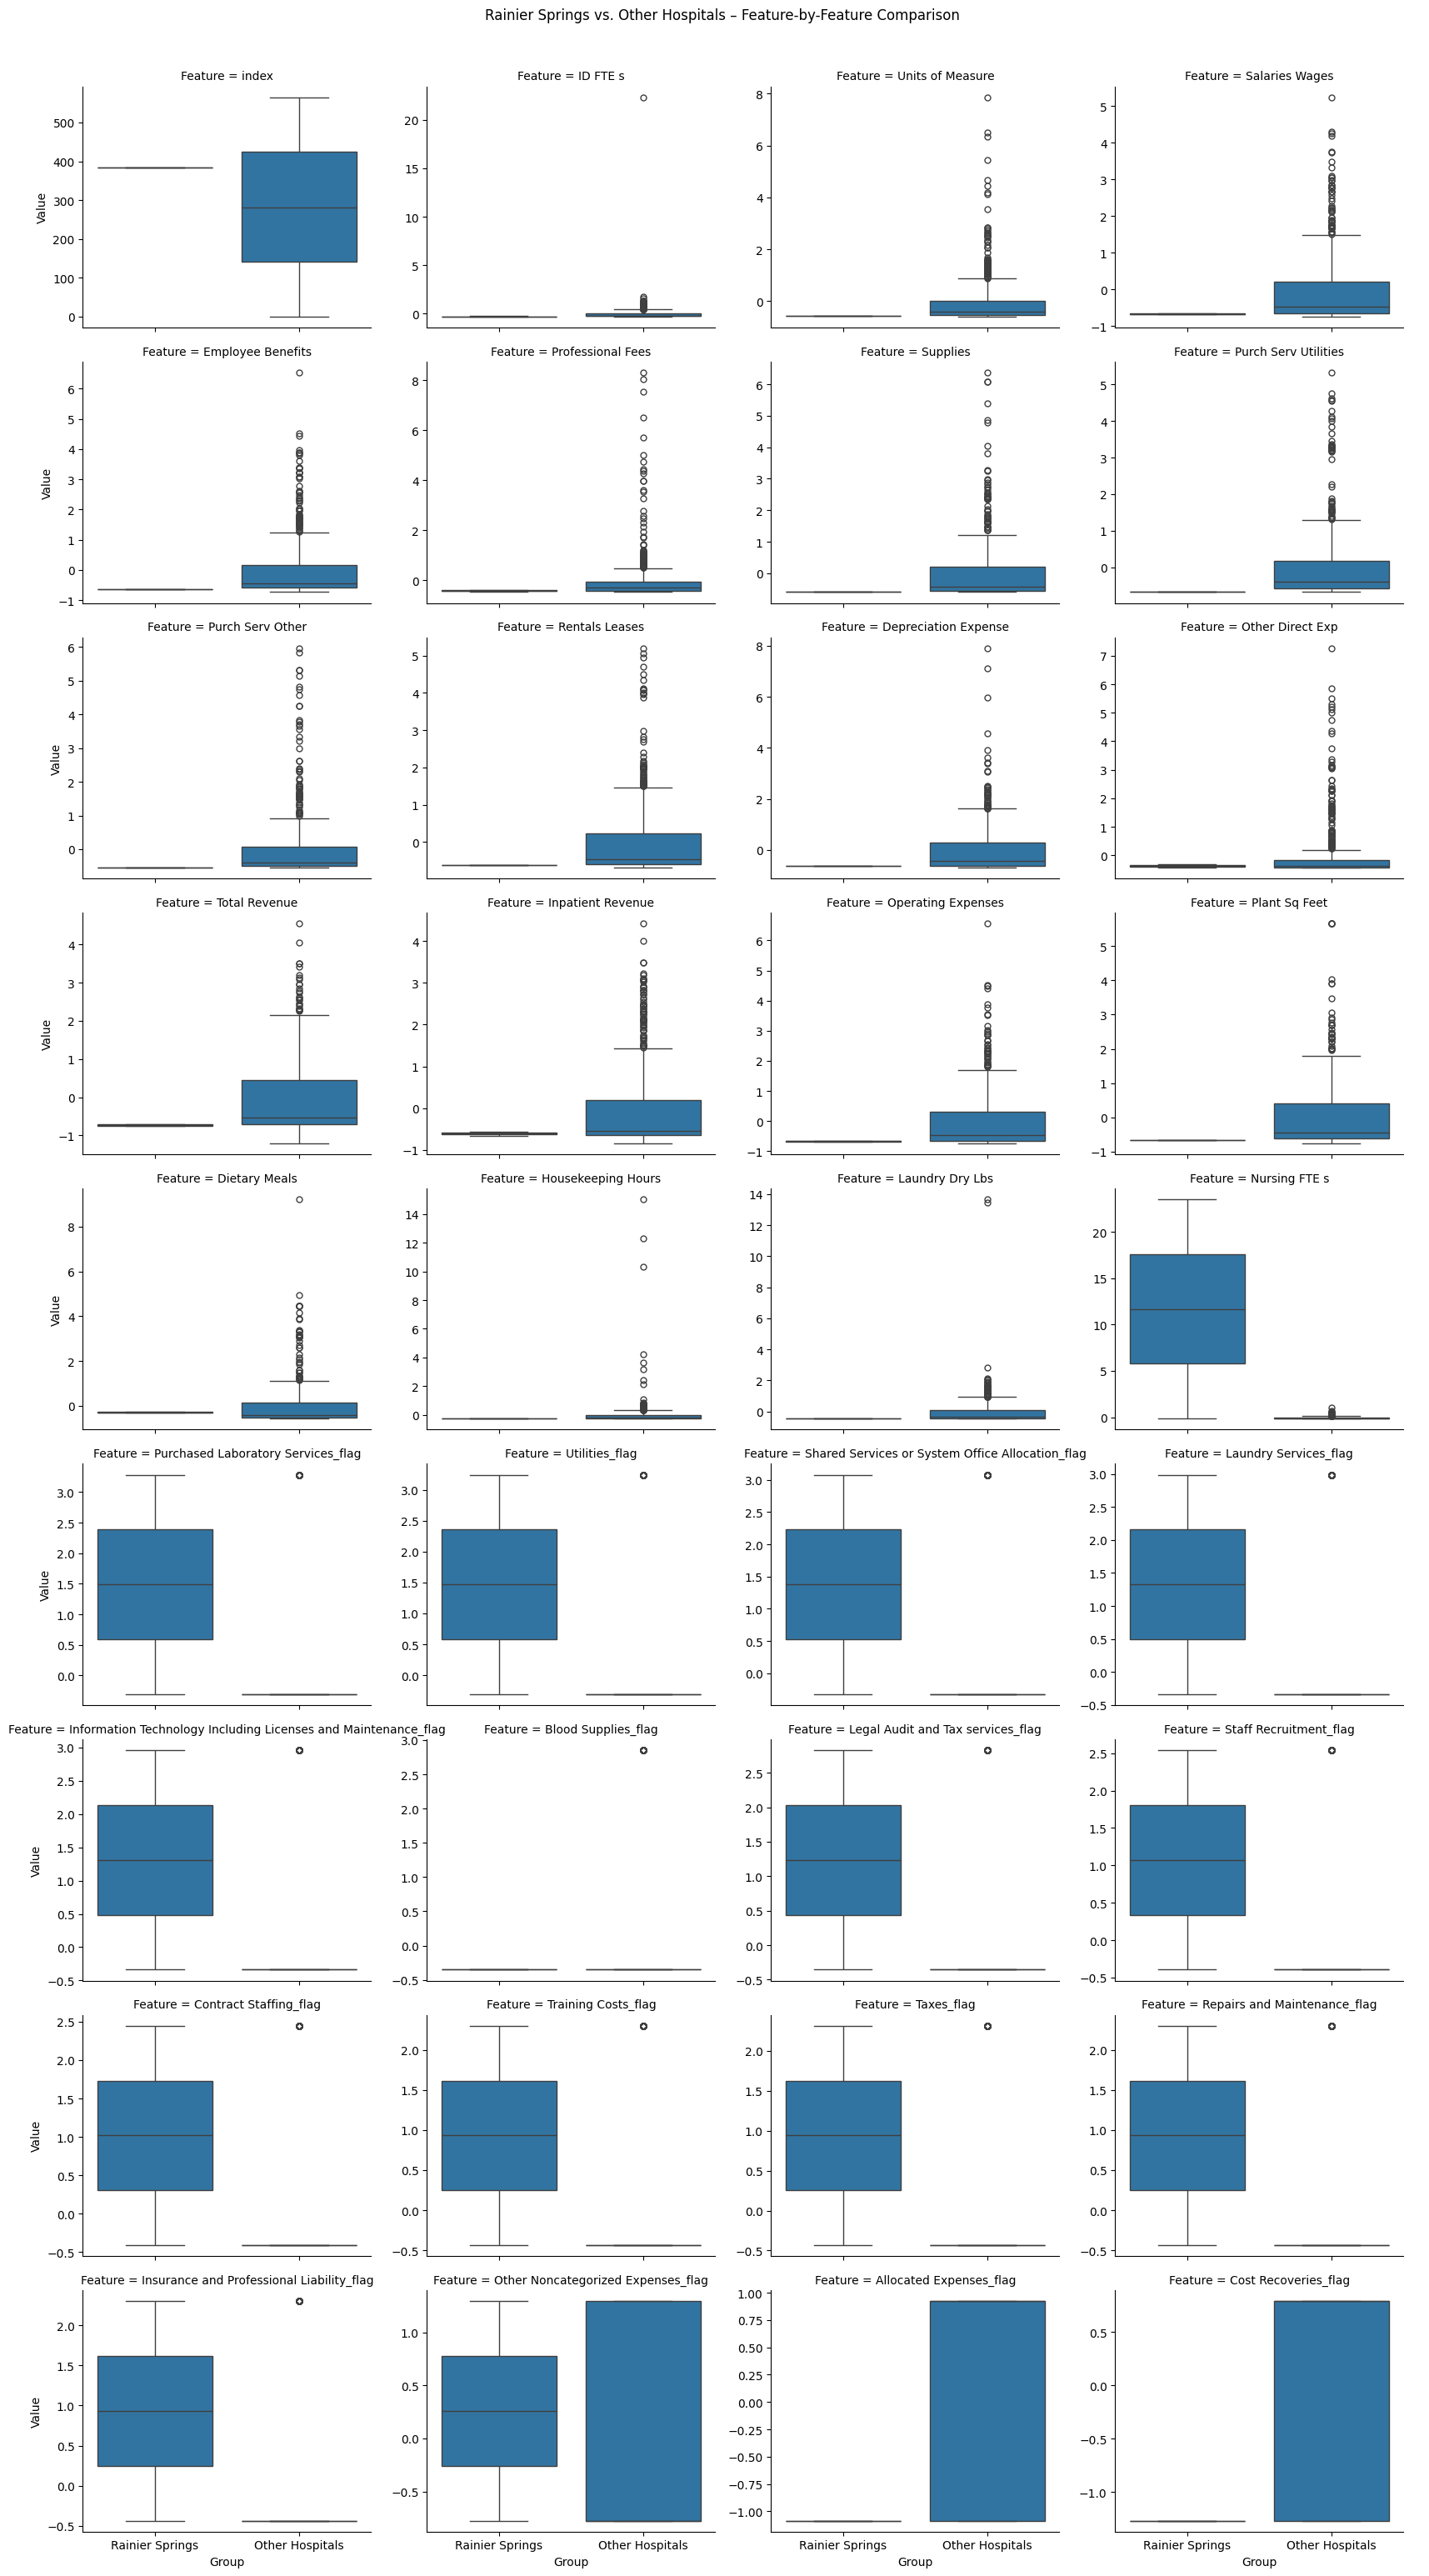

In [31]:
rainier_mask = df_meta['Hospital Name'] == 'Rainier Springs'
df_rainier = df_scaled[rainier_mask].copy()
df_other = df_scaled[~rainier_mask].copy()
df_rainier['Group'] = 'Rainier Springs'
df_other['Group'] = 'Other Hospitals'
df_combined = pd.concat([df_rainier, df_other])
df_melted = df_combined.reset_index().melt(id_vars='Group', var_name='Feature', value_name='Value')

g = sns.catplot(
    data=df_melted,
    x='Group',
    y='Value',
    col='Feature',
    col_wrap=4,
    kind='box',
    sharey=False,
    height=3.5,
    aspect=1.2
)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Rainier Springs vs. Other Hospitals – Feature-by-Feature Comparison")

plt.show()

## Hierarchical Clustering

In [17]:
!pip install ISLP


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
 

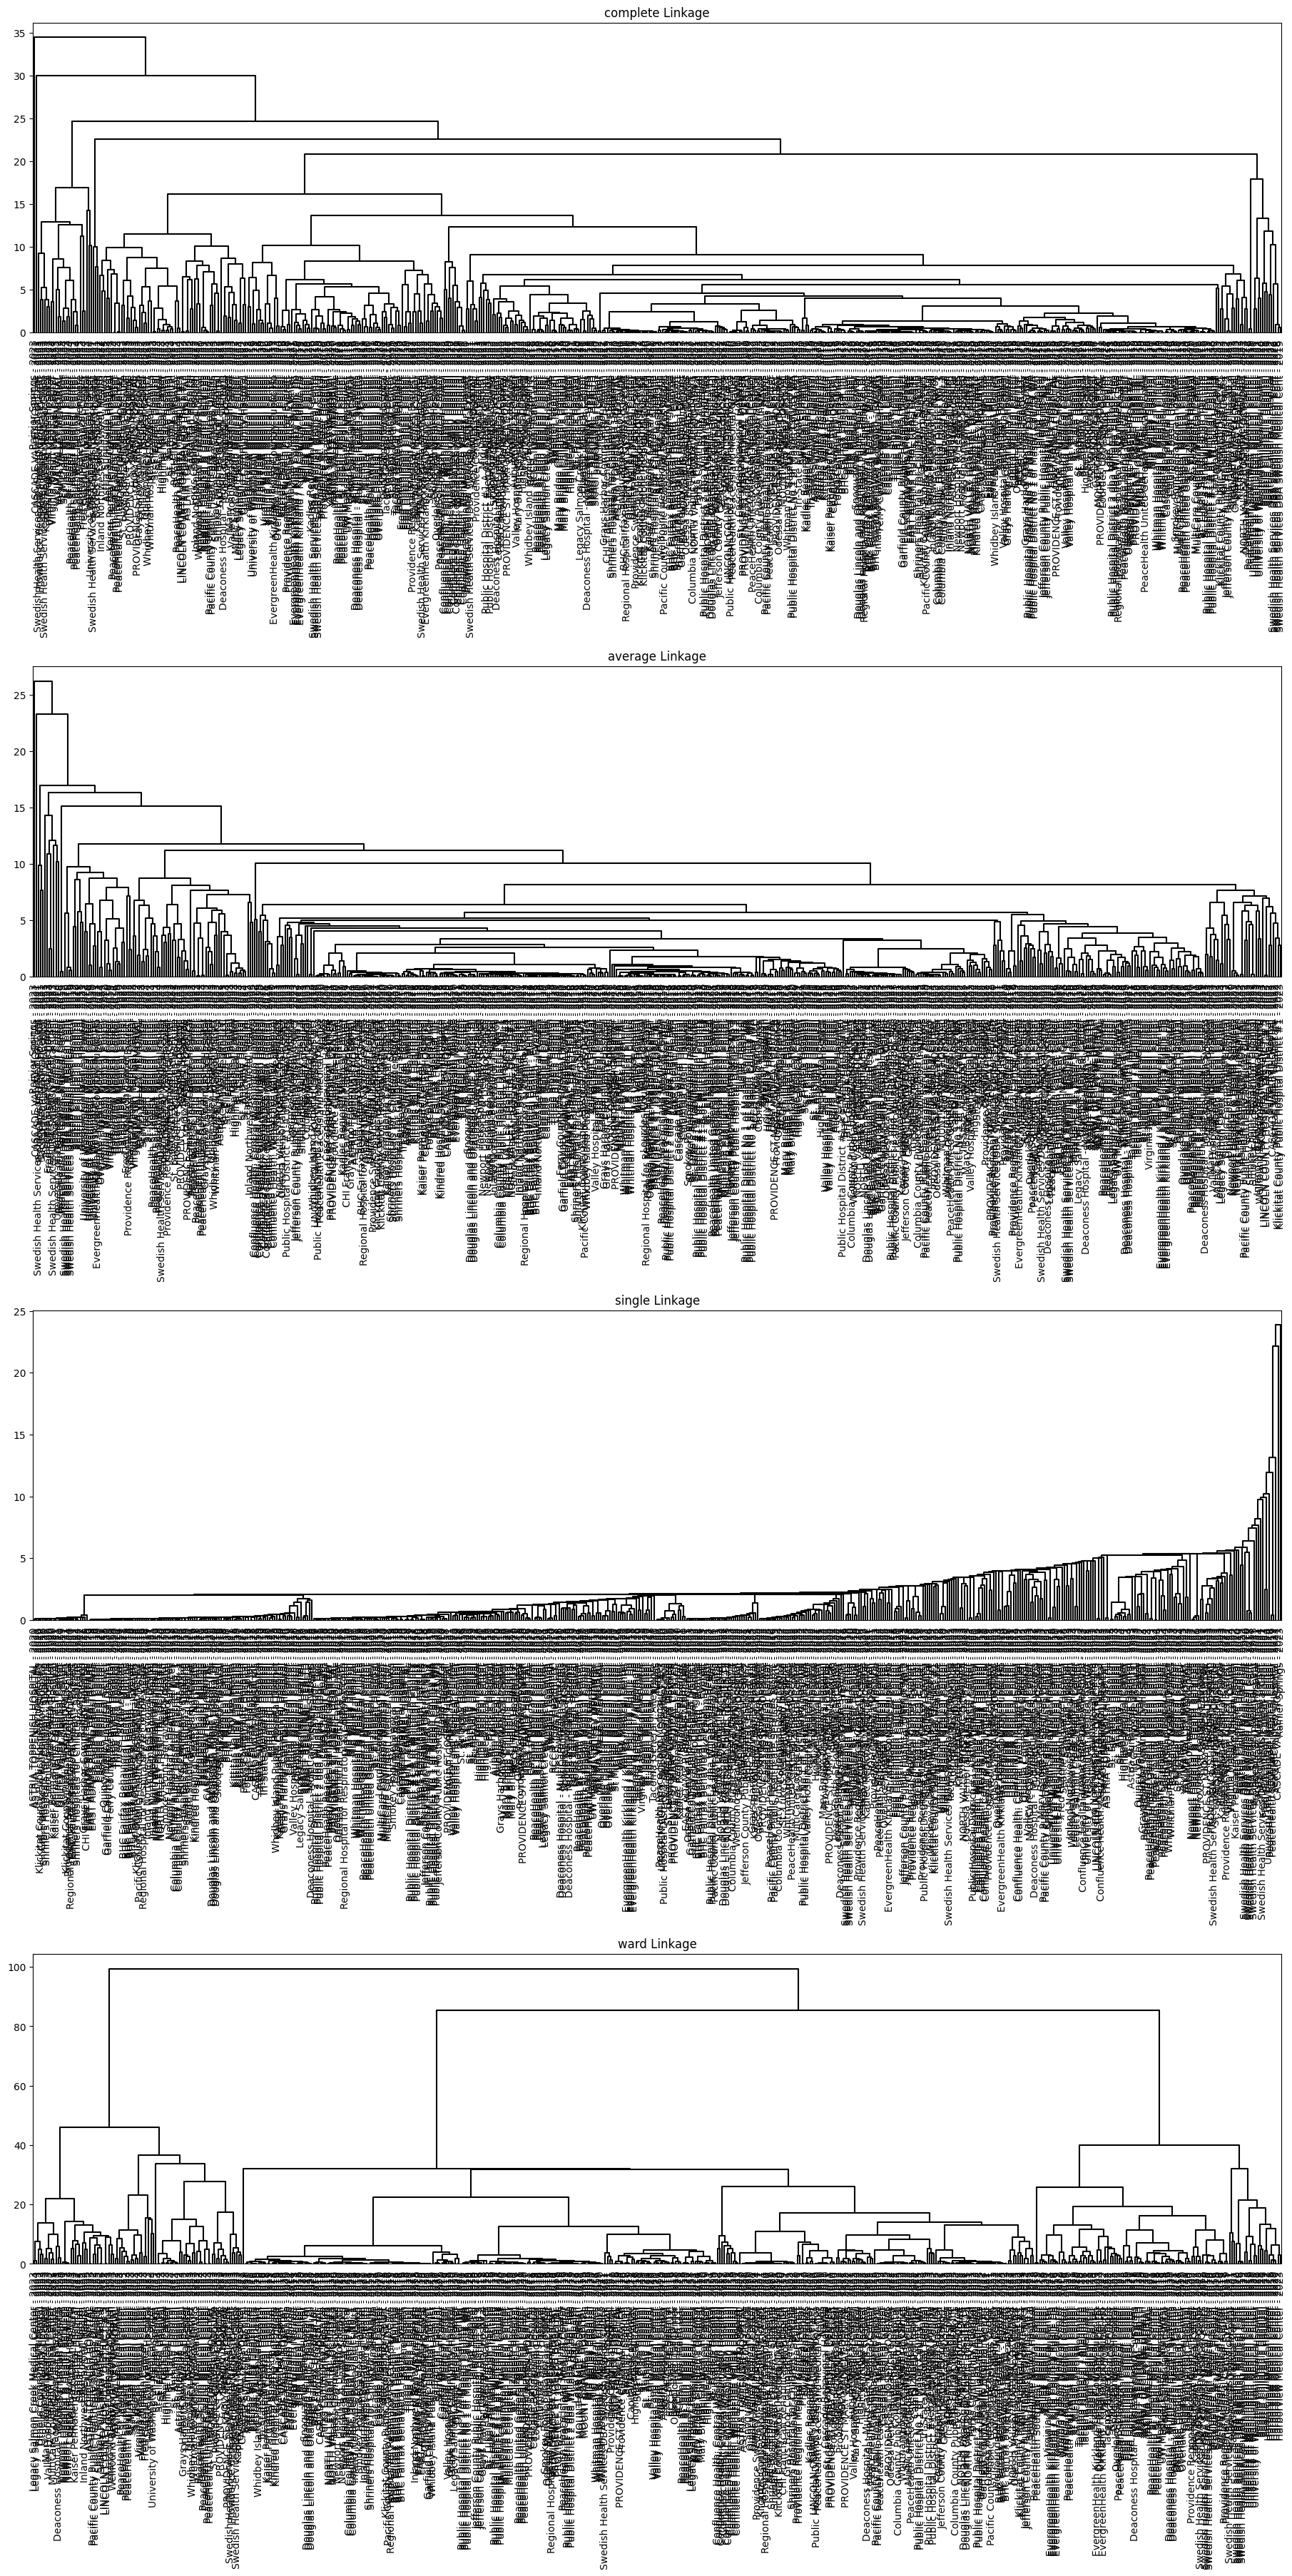

In [28]:
from ISLP.cluster import compute_linkage

# def compute_linkage(model):
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count
#     linkage_matrix = np.column_stack([
#         model.children_, model.distances_, counts
#     ]).astype(float)
#     return linkage_matrix

def plot_nci(linkage_method, ax, df_meta, cut=-np.inf):
    hc = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=0,
        linkage=linkage_method.lower()
    ).fit(df_scaled)

    linkage_ = compute_linkage(hc)
    labels = df_meta['Hospital Name'] + " - " + df_meta['Year'].astype(str)
    dendrogram(
        linkage_,
        ax=ax,
        labels=labels.to_list(),
        leaf_font_size=10,
        color_threshold=cut,
        above_threshold_color='black'
    )
    ax.set_title(f"{linkage_method} Linkage")
    return hc

fig, axes = plt.subplots(4, 1, figsize=(18, 36), constrained_layout=True)
plot_nci('complete', axes[0], df_meta)
plot_nci('average', axes[1], df_meta)
plot_nci('single', axes[2], df_meta)
plot_nci('ward', axes[3], df_meta)
plt.show()

Complete Linkage
- Good separation with some distinct clusters.
- No clear cut point, maybe something around ~15–20.

Average Linkage
- Smooth and ~balanced.
- We can observe some good ~3–6 clusters.

Single Linkage
- Long chaining effect.
- Not ideal for data

**Ward Linkage**
- Most structured, variance-minimizing clustering.
- Major merges happen around height 60–80.
- Tall merges (high height) point to the clusters being joined are far apart → strong separation.






Linkage: ward
Clusters: 2, Silhouette Score: 0.476
Clusters: 3, Silhouette Score: 0.419
Clusters: 4, Silhouette Score: 0.420
Clusters: 5, Silhouette Score: 0.386
Clusters: 6, Silhouette Score: 0.392
Clusters: 7, Silhouette Score: 0.393
Clusters: 8, Silhouette Score: 0.398
Clusters: 9, Silhouette Score: 0.402
Clusters: 10, Silhouette Score: 0.275
Clusters: 11, Silhouette Score: 0.281
Clusters: 12, Silhouette Score: 0.293
Clusters: 13, Silhouette Score: 0.301
Clusters: 14, Silhouette Score: 0.303

Linkage: complete
Clusters: 2, Silhouette Score: 0.735
Clusters: 3, Silhouette Score: 0.706
Clusters: 4, Silhouette Score: 0.516
Clusters: 5, Silhouette Score: 0.521
Clusters: 6, Silhouette Score: 0.522
Clusters: 7, Silhouette Score: 0.521
Clusters: 8, Silhouette Score: 0.503
Clusters: 9, Silhouette Score: 0.467
Clusters: 10, Silhouette Score: 0.467
Clusters: 11, Silhouette Score: 0.417
Clusters: 12, Silhouette Score: 0.420
Clusters: 13, Silhouette Score: 0.419
Clusters: 14, Silhouette Score: 

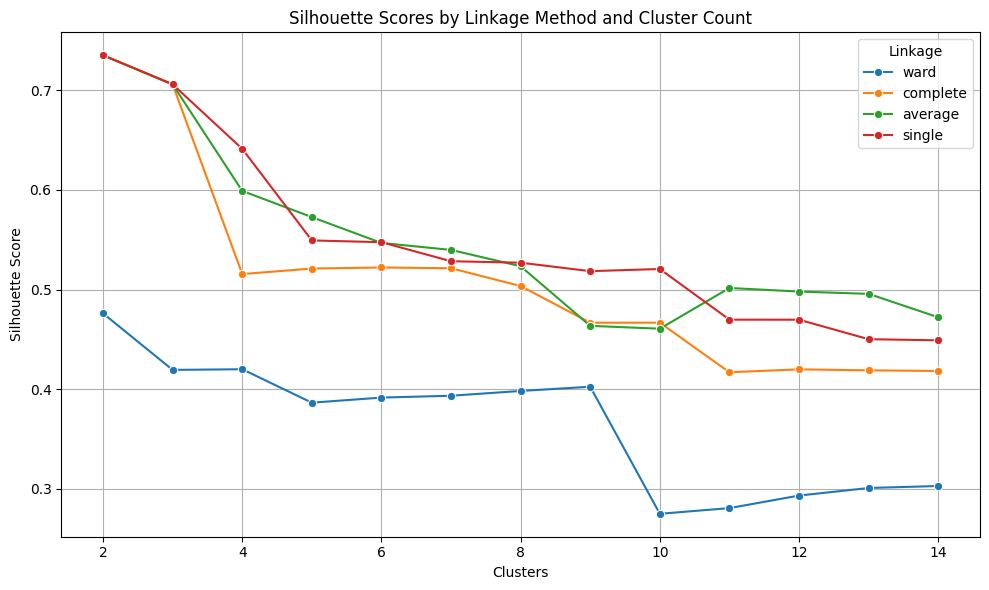

In [29]:
linkage_methods = ['ward', 'complete', 'average', 'single']
results = []

for linkage in linkage_methods:
    print(f"\nLinkage: {linkage}")
    for k in range(2, 15):
        try:
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels = model.fit_predict(df_scaled)
            score = silhouette_score(df_scaled, labels)
            results.append({'Linkage': linkage, 'Clusters': k, 'Silhouette Score': score})
            print(f"Clusters: {k}, Silhouette Score: {score:.3f}")
        except Exception as e:
            print(f"Clusters: {k}, Error: {e}")

# Convert results to DataFrame for plotting or further analysis
df_silhouette = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_silhouette, x='Clusters', y='Silhouette Score', hue='Linkage', marker='o')
plt.title("Silhouette Scores by Linkage Method and Cluster Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
model = AgglomerativeClustering(n_clusters=2, linkage='average')
labels = model.fit_predict(df_scaled)
df_meta['Cluster'] = labels
df_meta['Cluster'].value_counts()

# Inspect isolated hospital
df_meta[df_meta['Cluster'] == df_meta['Cluster'].value_counts().idxmin()]

Hospital Name  Year  License Number  Acct #  Cluster
385  Rainier Springs  2023           73075  601720        1

In [24]:
avg_model = AgglomerativeClustering(n_clusters=2, linkage='average')
avg_labels = avg_model.fit_predict(df_scaled)

# Merge labels into metadata
df_meta_avg = df_meta.copy()
df_meta_avg['Cluster'] = avg_labels

# Count how many hospitals are in each cluster
print(df_meta_avg['Cluster'].value_counts())

# Get the hospital(s) in the smaller cluster
df_meta_avg[df_meta_avg['Cluster'] == df_meta_avg['Cluster'].value_counts().idxmin()]


Cluster
0    565
1      1
Name: count, dtype: int64


Hospital Name  Year  License Number  Acct #  Cluster
385  Rainier Springs  2023           73075  601720        1

In [25]:
df_scaled.loc[df_meta['Hospital Name'] == 'Rainier Springs']


ID FTE s  Units of Measure  Salaries Wages  Employee Benefits  \
384 -0.274733         -0.563551       -0.668670          -0.633979   
385 -0.272199         -0.559140       -0.657038          -0.631406   

     Professional Fees  Supplies  Purch Serv Utilities  Purch Serv Other  \
384          -0.373287 -0.598535             -0.676143         -0.540599   
385          -0.447262 -0.594140             -0.676143         -0.535172   

     Rentals Leases  Depreciation Expense  ...  \
384       -0.621924             -0.619933  ...   
385       -0.621924             -0.625648  ...   

     Legal Audit and Tax services_flag  Staff Recruitment_flag  \
384                                  0                       0   
385                                  1                       1   

     Contract Staffing_flag  Training Costs_flag  Taxes_flag  \
384                       0                    0           0   
385                       1                    1           1   

     Repairs and Maintenance_flag  Insurance and Professional Liability_flag  \
384                             0                                          0   
385                             1                                          1   

     Other Noncategorized Expenses_flag  Allocated Expenses_flag  \
384                                   0                        0   
385                                   1                        0   

     Cost Recoveries_flag  
384                     0  
385                     0  

[2 rows x 35 columns]

In [32]:
df.loc[
    (df['Year'] == 2023) &
    (df['License Number'] == 925) &
    (df['Hospital Name'].str.strip() == 'Rainier Springs') &
    (df['Cost Center'].str.strip() == 'Psychiatric Care') &
    (df['Nursing FTE s'] > 10000),
    'Nursing FTE s'
] = np.nan

meta_cols = ['Hospital Name', 'Year', 'License Number', 'Acct #', 'Cost Center']
df_numeric = df.drop(columns=meta_cols).apply(pd.to_numeric, errors='coerce')
df_agg = pd.concat([df[['Hospital Name', 'Year']], df_numeric], axis=1)
df_agg = df_agg.groupby(['Hospital Name', 'Year']).sum(numeric_only=True).reset_index()

sparse_service_cols = [
    "Purchased Laboratory Services", "Utilities",
    "Shared Services or System Office Allocation", "Laundry Services",
    "Information Technology Including Licenses and Maintenance",
    "Blood Supplies", "Legal Audit and Tax services", "Staff Recruitment",
    "Contract Staffing", "Training Costs", "Taxes", "Repairs and Maintenance",
    "Insurance and Professional Liability", "Other Noncategorized Expenses",
    "Allocated Expenses", "Cost Recoveries"
]
for col in sparse_service_cols:
    df_agg[col + "_flag"] = (df_agg[col] > 0).astype(int)

df_encoded = df_agg.drop(columns=sparse_service_cols)

binary_cols = [col for col in df_encoded.columns if col.endswith('_flag')]
meta_cols_encoded = ['Hospital Name', 'Year']
numeric_cols = [col for col in df_encoded.columns if col not in meta_cols_encoded + binary_cols]

df_meta = df_encoded[meta_cols_encoded].reset_index(drop=True)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded[numeric_cols + binary_cols]), columns=numeric_cols + binary_cols)

AttributeError: 'numpy.ndarray' object has no attribute 'to_list'

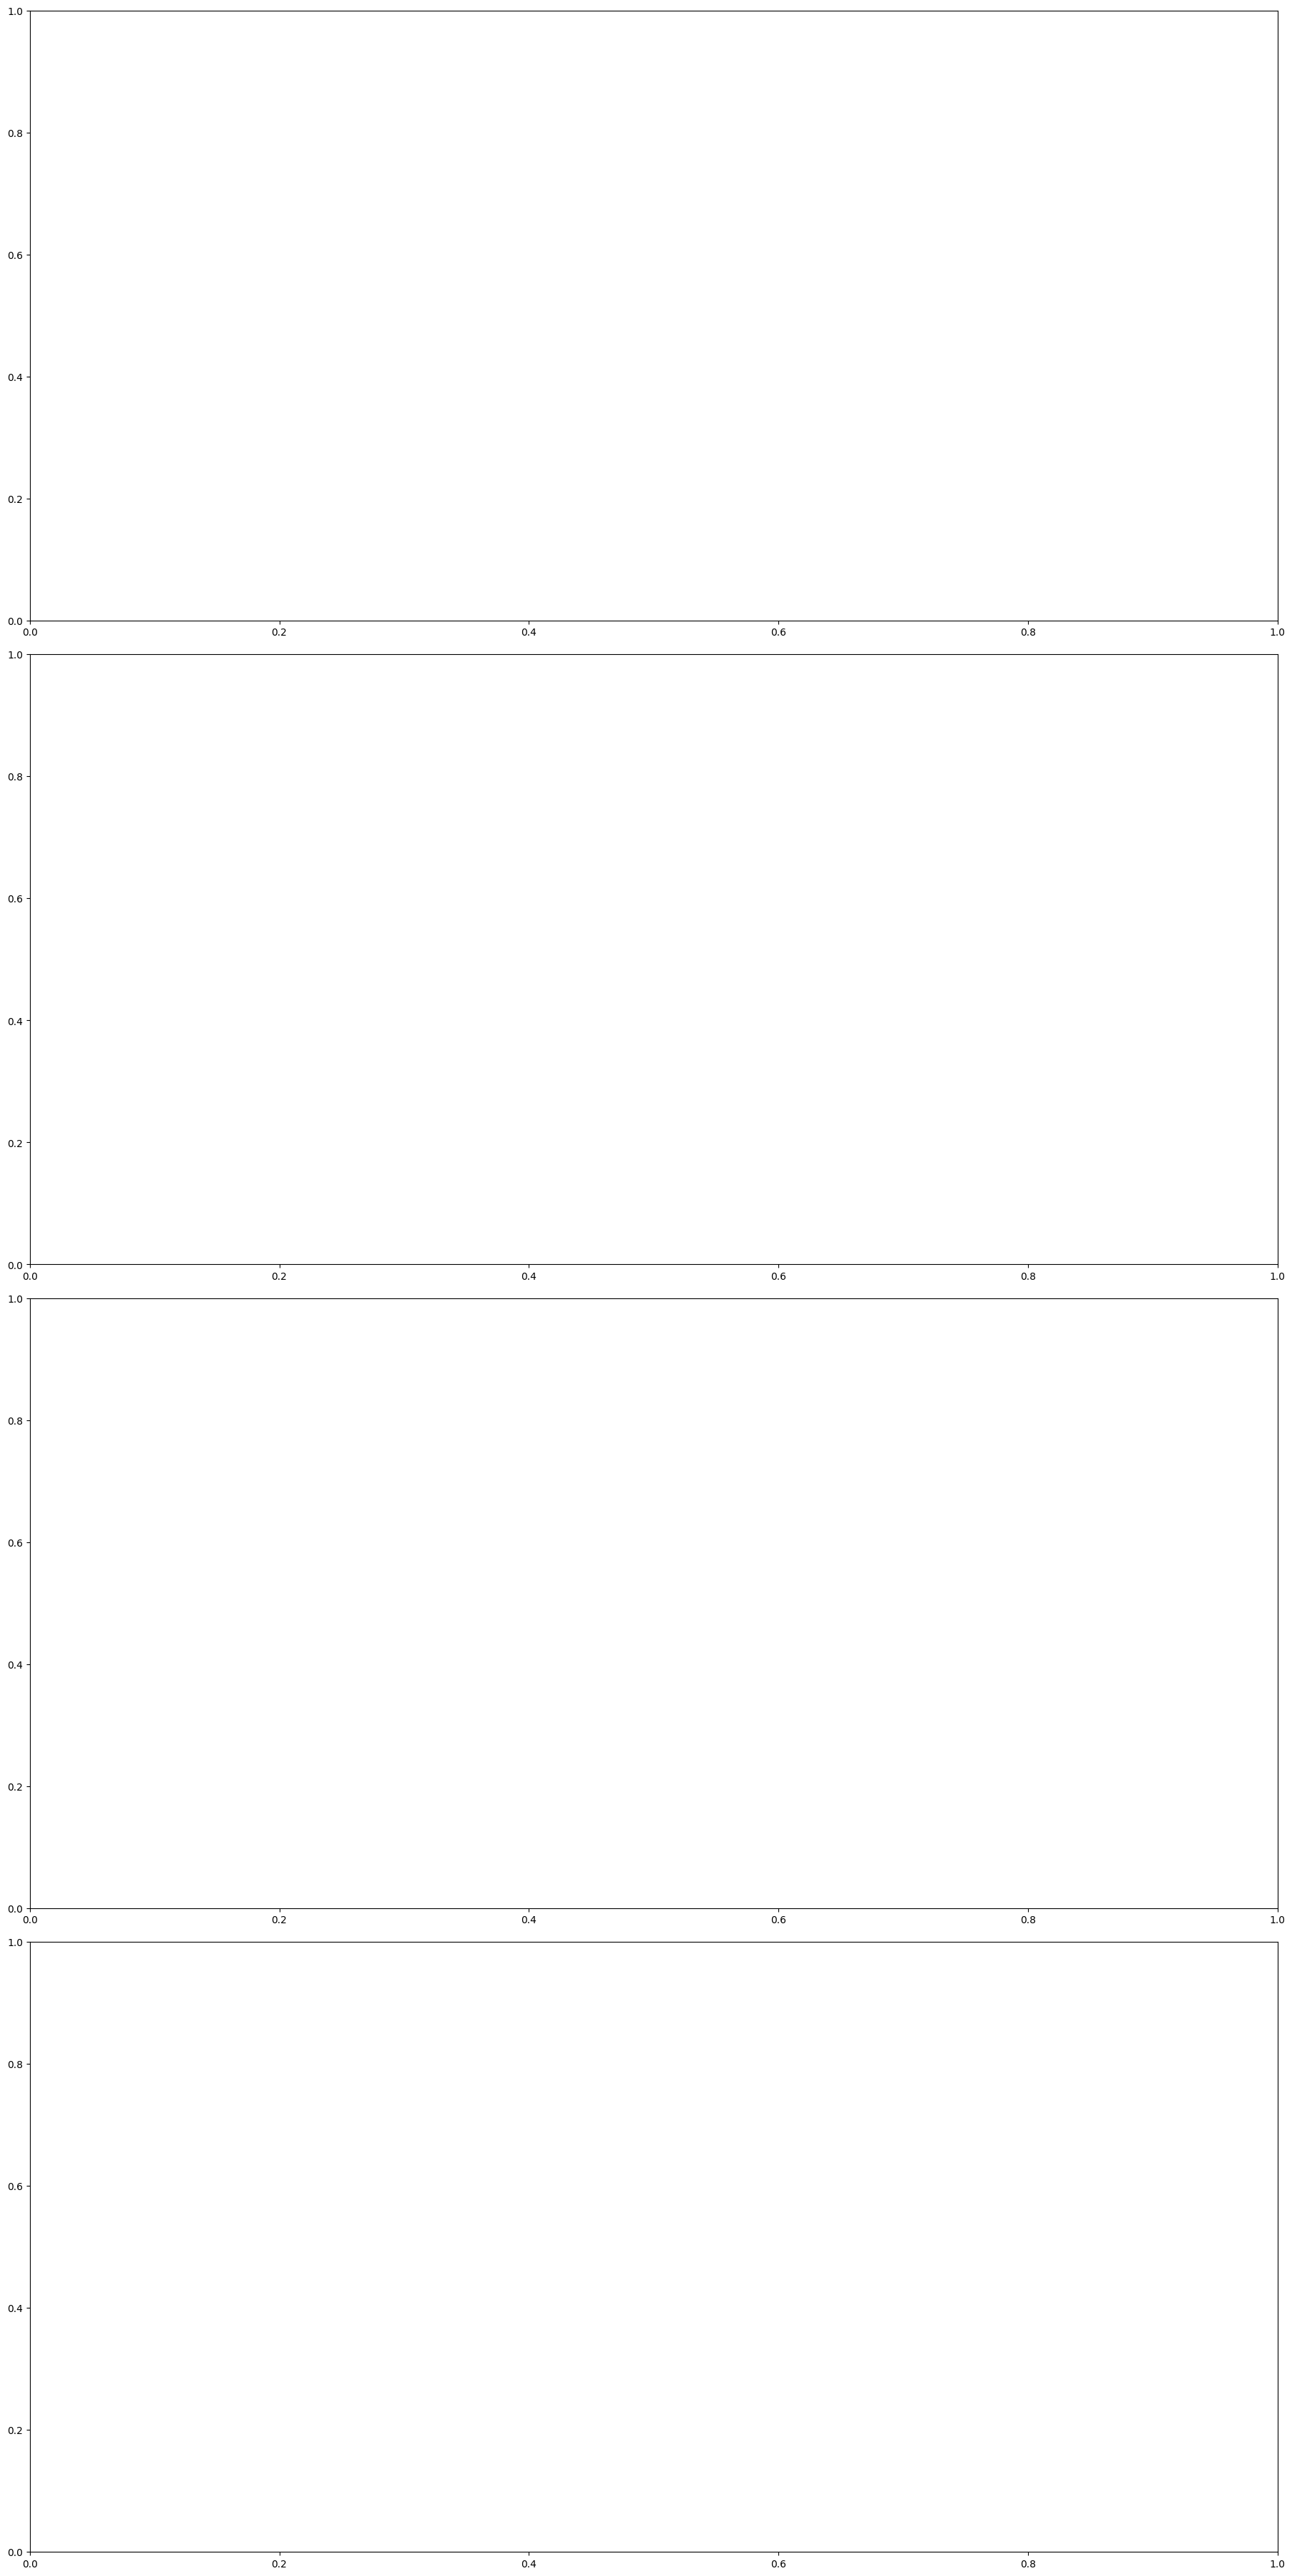

In [33]:
fig, axes = plt.subplots(4, 1, figsize=(18, 36), constrained_layout=True)
plot_nci('complete', axes[0])
plot_nci('average', axes[1])
plot_nci('single', axes[2])
plot_nci('ward', axes[3])
plt.show()

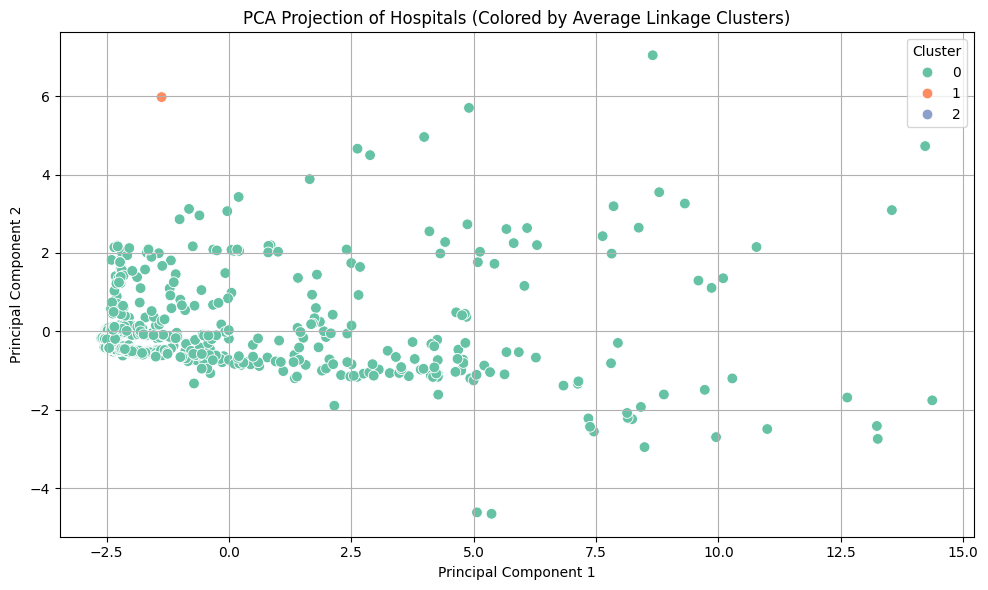

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=60)
plt.title("PCA Projection of Hospitals (Colored by Average Linkage Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

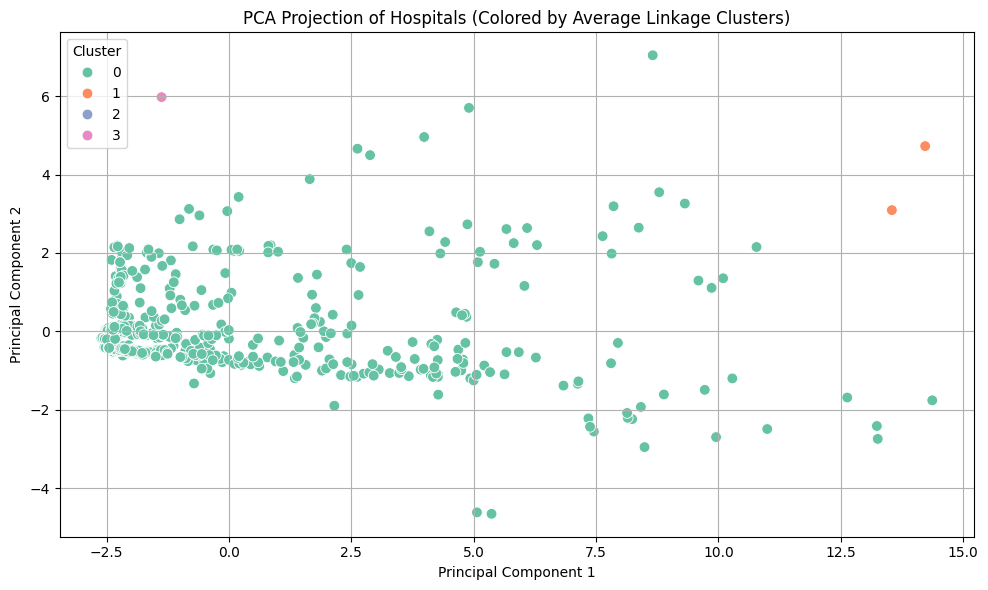

In [ ]:
avg_model = AgglomerativeClustering(n_clusters=4, linkage='average')
avg_labels = avg_model.fit_predict(df_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)


# Store PCA results with cluster labels
df_pca = df_meta.copy()
df_pca['PC1'] = X_pca[:, 0]
df_pca['PC2'] = X_pca[:, 1]
df_pca['Cluster'] = avg_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=60)
plt.title("PCA Projection of Hospitals (Colored by Average Linkage Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


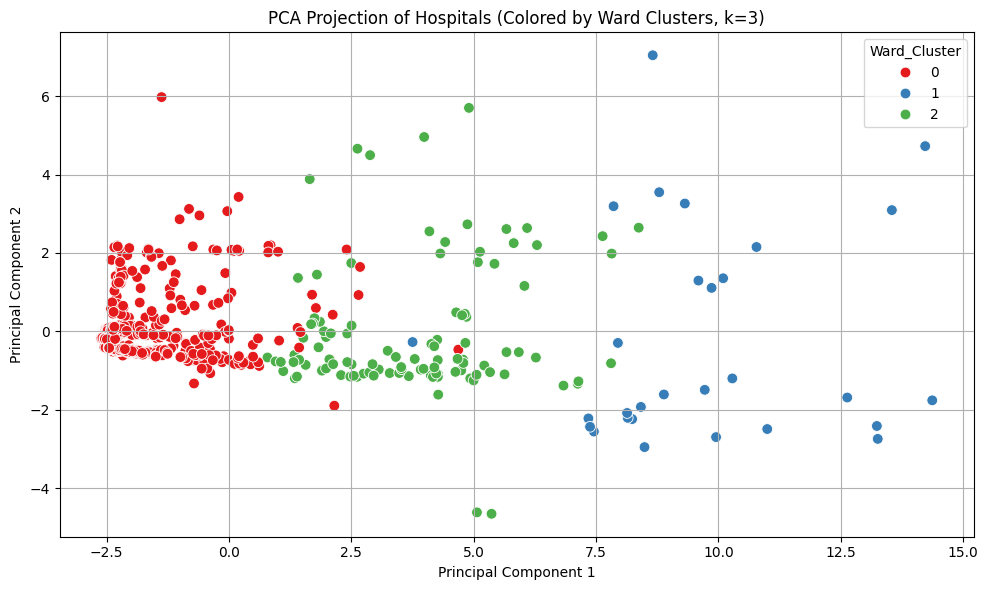

In [ ]:
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
ward_labels = agg.fit_predict(df_scaled)

df_pca['Ward_Cluster'] = ward_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Ward_Cluster', palette='Set1', s=60)
plt.title("PCA Projection of Hospitals (Colored by Ward Clusters, k=3)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_pca[['Hospital Name', 'Year', 'Ward_Cluster']].groupby('Ward_Cluster').head()


Hospital Name  Year  Ward_Cluster
0                        ASTRIA TOPPENISH HOSPITAL  2020             0
1                        ASTRIA TOPPENISH HOSPITAL  2021             0
2                        ASTRIA TOPPENISH HOSPITAL  2022             0
3                        ASTRIA TOPPENISH HOSPITAL  2023             0
4                                     Arbor Health  2019             0
77   Deaconess Hospital - MultiCare Health Systems  2018             2
78   Deaconess Hospital - MultiCare Health Systems  2019             2
79   Deaconess Hospital - MultiCare Health Systems  2020             2
80   Deaconess Hospital - MultiCare Health Systems  2021             2
81   Deaconess Hospital - MultiCare Health Systems  2022             2
116                  Fred Hutchinson Cancer Center  2023             1
117                  Fred Hutchinson Cancer Center  2024             1
146                      Harborview Medical Center  2018             1
147                      Harborview Medical Center  2019             1
148                      Harborview Medical Center  2020             1

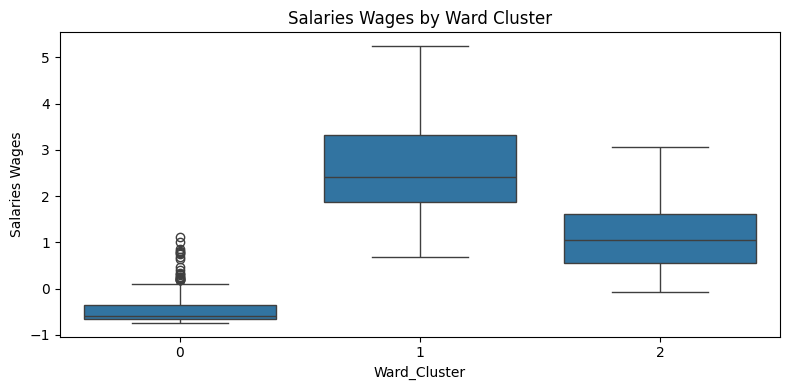

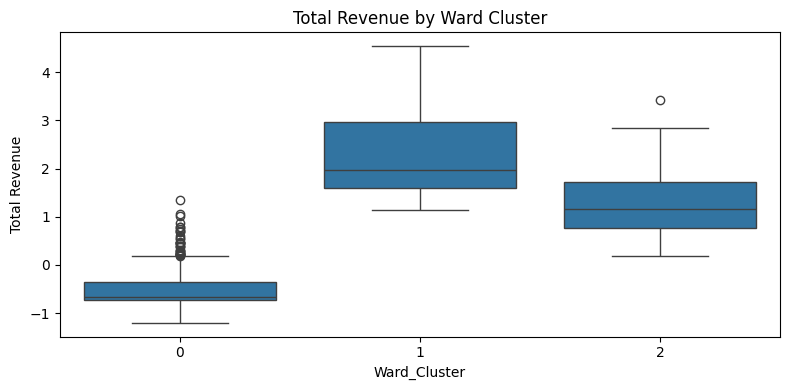

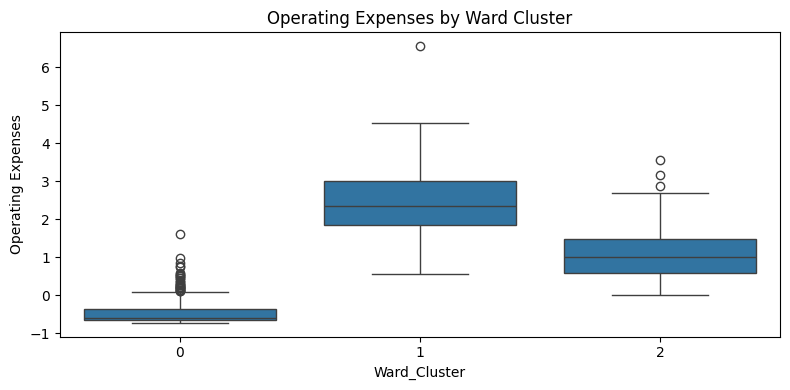

In [ ]:
df_plot = df_scaled.copy()
df_plot['Ward_Cluster'] = df_pca['Ward_Cluster'].values

# Choose top features to compare (or loop through all)
features_to_plot = ['Salaries Wages', 'Total Revenue', 'Operating Expenses']  # replace or extend

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_plot, x='Ward_Cluster', y=feature)
    plt.title(f'{feature} by Ward Cluster')
    plt.tight_layout()
    plt.show()

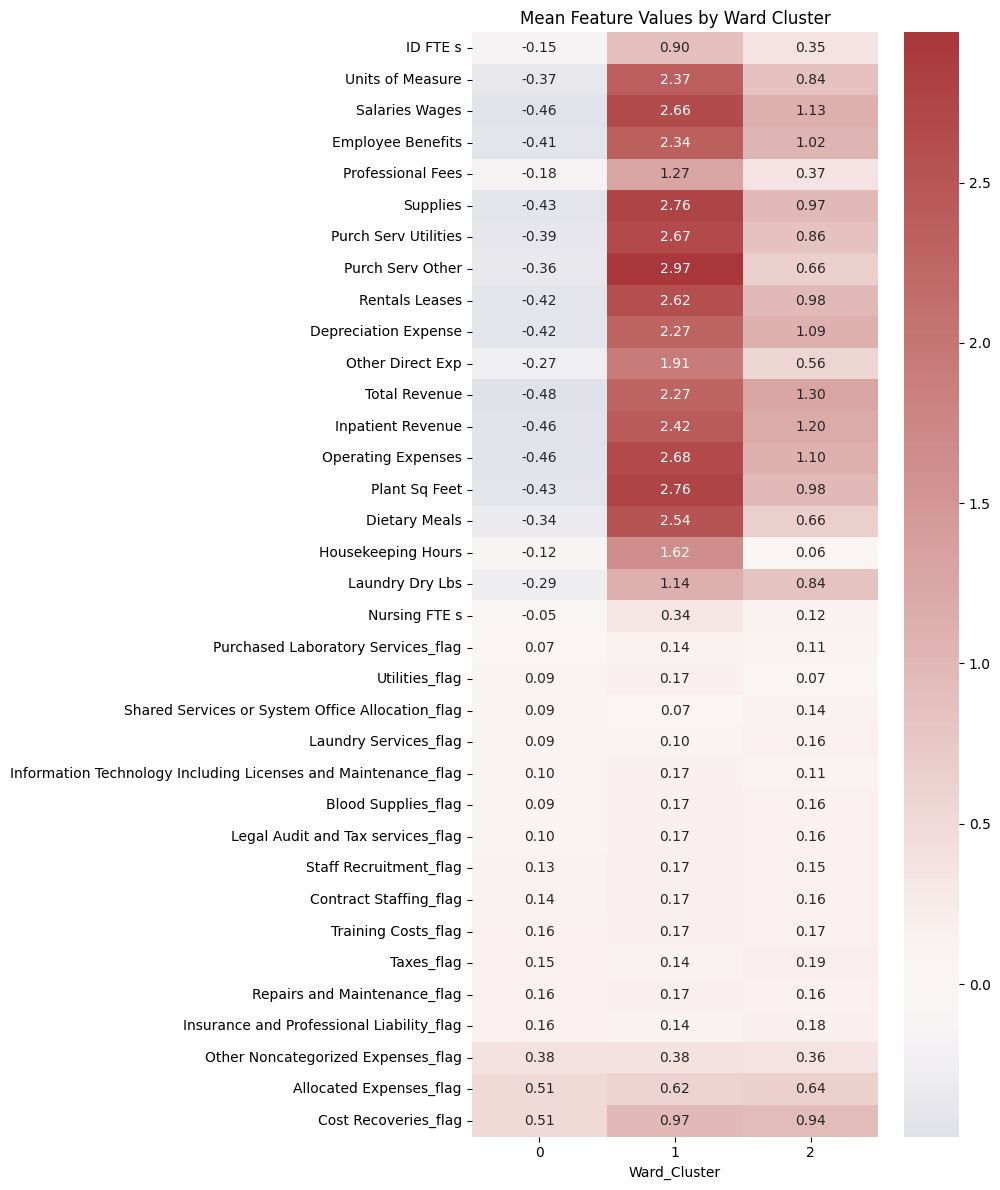

In [ ]:
cluster_means = df_plot.groupby('Ward_Cluster').mean().T

# Plot as heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Mean Feature Values by Ward Cluster")
plt.tight_layout()
plt.show()

The most distinguishing features include:

- **High-cost items**: Salaries Wages, Supplies, Operating Expenses
- **Infrastructure flags**: Presence of Cost Recoveries, Allocated Expenses
- **Unit-based usage**: Dietary Meals, Plant Sq Feet, Laundry Dry Lbs

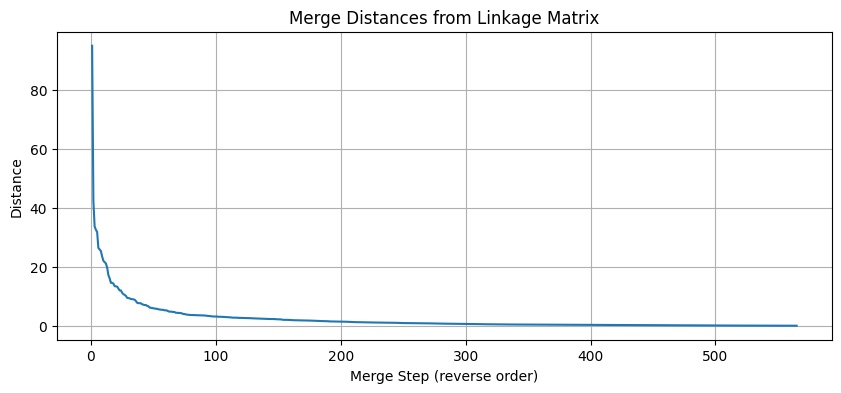

In [ ]:
distances = linkage_matrix[:, 2]

# Plot merge distances to identify elbow
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(distances) + 1), sorted(distances, reverse=True))
plt.xlabel("Merge Step (reverse order)")
plt.ylabel("Distance")
plt.title("Merge Distances from Linkage Matrix")
plt.grid(True)
plt.show()

In [ ]:
ward_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward').fit(df_scaled)

# Compute linkage matrix from model
def compute_linkage(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    return linkage_matrix

linkage_matrix = compute_linkage(ward_model)

# Cut the dendrogram at a chosen threshold to define clusters
cut_threshold = 25  # adjust this for more or fewer clusters
clusters = fcluster(linkage_matrix, t=cut_threshold, criterion='distance')

# Add clusters to metadata
df_meta_clustered = df_meta.copy()
df_meta_clustered['Cluster'] = clusters

# Analyze: count of hospitals and years per cluster
cluster_by_hospital = df_meta_clustered.groupby(['Cluster', 'Hospital Name']).size().unstack(fill_value=0)
cluster_by_year = df_meta_clustered.groupby(['Cluster', 'Year']).size().unstack(fill_value=0)

# Display summaries
print("Clusters by Hospital:\n", cluster_by_hospital)
print("\nClusters by Year:\n", cluster_by_year)

# Optional: preview first few rows
df_meta_clustered.head()

Clusters by Hospital:
 Hospital Name  ASTRIA TOPPENISH HOSPITAL  Arbor Health  \
Cluster                                                  
1                                      2             1   
2                                      0             0   
3                                      2             4   
4                                      0             0   
5                                      0             0   
6                                      0             0   
7                                      0             0   
8                                      0             0   
9                                      0             0   

Hospital Name  Astria Sunnyside Hospital  Auburn Medical Center  \
Cluster                                                           
1                                      2                      0   
2                                      0                      0   
3                                      3                      5   
4  

Hospital Name  Year  License Number  Acct #  Cluster
0  ASTRIA TOPPENISH HOSPITAL  2020            6766  291190        3
1  ASTRIA TOPPENISH HOSPITAL  2021            6766  291190        3
2  ASTRIA TOPPENISH HOSPITAL  2022           15721  601720        1
3  ASTRIA TOPPENISH HOSPITAL  2023           15721  601720        1
4               Arbor Health  2019           13840  610720        3